            Unnamed: 0       open       high        low      close    volume  \
0  2017-09-25 12:00:00  4201000.0  4224000.0  4195000.0  4224000.0  8.518420   
1  2017-09-25 12:05:00  4225000.0  4241000.0  4208000.0  4227000.0  7.421608   
2  2017-09-25 12:10:00  4215000.0  4236000.0  4212000.0  4227000.0  6.693031   
3  2017-09-25 12:15:00  4227000.0  4244000.0  4210000.0  4227000.0  9.531738   
4  2017-09-25 12:20:00  4215000.0  4242000.0  4203000.0  4215000.0  9.113169   

          value  
0  3.585738e+07  
1  3.137140e+07  
2  2.826349e+07  
3  4.027968e+07  
4  3.846652e+07  


c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/50], Loss: 0.0001
Epoch [2/50], Loss: 0.0001
Epoch [3/50], Loss: 0.0001
Epoch [4/50], Loss: 0.0000
Epoch [5/50], Loss: 0.0000
Epoch [6/50], Loss: 0.0000
Epoch [7/50], Loss: 0.0000
Epoch [8/50], Loss: 0.0000
Epoch [9/50], Loss: 0.0000
Epoch [10/50], Loss: 0.0004
Epoch [11/50], Loss: 0.0000
Epoch [12/50], Loss: 0.0000
Epoch [13/50], Loss: 0.0000
Epoch [14/50], Loss: 0.0000
Epoch [15/50], Loss: 0.0000
Epoch [16/50], Loss: 0.0000
Epoch [17/50], Loss: 0.0000
Epoch [18/50], Loss: 0.0000
Epoch [19/50], Loss: 0.0000
Epoch [20/50], Loss: 0.0000
Epoch [21/50], Loss: 0.0001
Epoch [22/50], Loss: 0.0000
Epoch [23/50], Loss: 0.0000
Epoch [24/50], Loss: 0.0000
Epoch [25/50], Loss: 0.0000
Epoch [26/50], Loss: 0.0000
Epoch [27/50], Loss: 0.0000
Epoch [28/50], Loss: 0.0000
Epoch [29/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0001
Epoch [31/50], Loss: 0.0000
Epoch [32/50], Loss: 0.0000
Epoch [33/50], Loss: 0.0000
Epoch [34/50], Loss: 0.0000
Epoch [35/50], Loss: 0.0001
Epoch [36/50], Loss: 0.0000
E

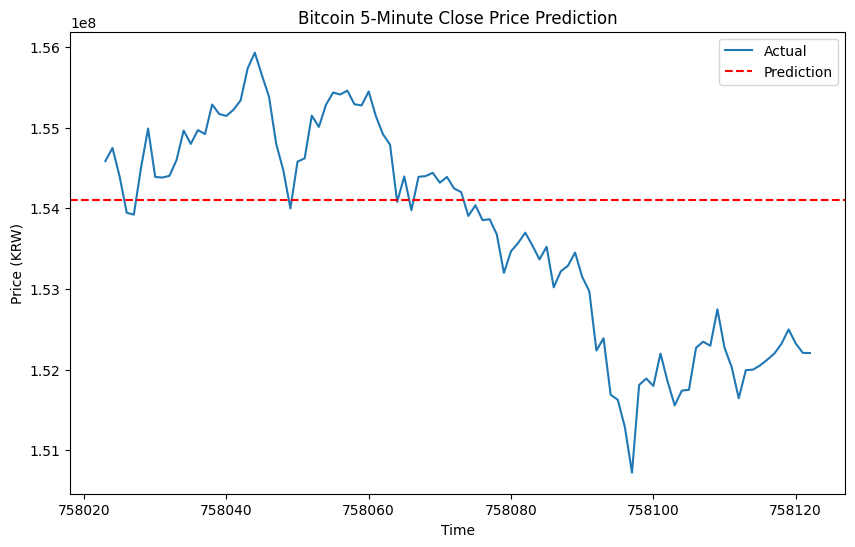

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
file_path = 'BTC_upbit_KRW_min5.csv'  # 파일 경로를 올바르게 설정하세요.
data = pd.read_csv(file_path)

# 데이터 확인
print(data.head())

# 필요한 컬럼만 선택 (Open, High, Low, Close, Volume)
ohlcv = data[['open', 'high', 'low', 'close', 'volume']].values

# 2. 데이터 정규화
scaler = MinMaxScaler()
ohlcv = scaler.fit_transform(ohlcv)

# 3. 시퀀스 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 3])  # 종가(Close) 예측
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

SEQ_LENGTH = 48  # 예를 들어 48개의 5분봉 데이터를 이용해 예측 (4시간 분량)
X, y = create_sequences(ohlcv, SEQ_LENGTH)

# 4. 데이터셋 및 데이터로더 정의
class BitcoinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].to(device), self.y[idx].to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = BitcoinDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 5. 트랜스포머 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim):
        super(TransformerModel, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim),
            num_layers=num_layers
        )
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.transformer(x)
        x = self.fc(x[-1])  # 마지막 시퀀스의 출력을 사용
        return x

model = TransformerModel(input_dim=5, num_heads=1, num_layers=2, hidden_dim=64).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 6. 모델 훈련
EPOCHS = 50
for epoch in range(EPOCHS):
    for batch_X, batch_y in dataloader:
        batch_X = batch_X.permute(1, 0, 2)  # (batch, seq, feature) -> (seq, batch, feature)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

# 7. 모델 평가 및 예측
model.eval()
test_seq = X[-1].unsqueeze(1).to(device)  # 마지막 시퀀스
prediction = model(test_seq).item()
predicted_close = scaler.inverse_transform([[0, 0, 0, prediction, 0]])[0, 3]
print(f'Predicted Close Price: {predicted_close:.2f}')

# 8. 실제값과 예측값 시각화
plt.figure(figsize=(10, 6))
plt.plot(data.index[-100:], data['close'].values[-100:], label='Actual')
plt.axhline(y=predicted_close, color='r', linestyle='--', label='Prediction')
plt.legend()
plt.title('Bitcoin 5-Minute Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (KRW)')
plt.show()


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

# 1. 데이터 준비: SMA, 볼린저 밴드, RSI, MACD 계산
def calculate_indicators(data):
    # 이동 평균 (SMA) 계산
    sma_windows = [5, 10, 20, 60, 120, 250]
    for window in sma_windows:
        data[f'{window}SMA'] = data['close'].rolling(window=window).mean()

    # 볼린저 밴드 계산
    rolling_mean = data['close'].rolling(window=20).mean()
    rolling_std = data['close'].rolling(window=20).std()
    data['BB_Middle'] = rolling_mean
    data['BB_Upper'] = rolling_mean + (rolling_std * 2)
    data['BB_Lower'] = rolling_mean - (rolling_std * 2)

    # RSI 계산
    delta = data['close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)  # 방어적 나눗셈
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD 계산
    exp1 = data['close'].ewm(span=12, adjust=False).mean()
    exp2 = data['close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp1 - exp2
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    return data

# 데이터 불러오기 및 지표 계산
data = pd.read_csv("BTC_upbit_KRW_min5.csv")
data = calculate_indicators(data)

# 계산 후 NA 값 제거
data = data.dropna()

# 데이터를 피쳐와 타겟으로 나누고 정규화
features = ['open', 'high', 'low', 'close', 'volume', '5SMA', '10SMA', '20SMA', '60SMA', '120SMA', '250SMA', 'BB_Upper', 'BB_Lower', 'RSI', 'MACD', 'MACD_Signal']
data = data[features].values
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Tensor로 변환
data_tensor = torch.tensor(data, dtype=torch.float32)

# 데이터셋 클래스 정의 및 데이터 로더 생성
class BTCMinuteDataset(Dataset):
    def __init__(self, data, seq_length=120, mask_length=10):
        self.data = data
        self.seq_length = seq_length
        self.mask_length = mask_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        seq = self.data[idx:idx + self.seq_length]
        input_seq = seq[:-self.mask_length]
        target_seq = seq[-self.mask_length:]
        mask = torch.zeros_like(target_seq)
        mask_indices = torch.randperm(self.mask_length)[:int(self.mask_length * 0.5)]
        mask[mask_indices] = 1
        masked_target = target_seq.clone()
        masked_target[mask == 0] = -1  # 마스킹되지 않은 데이터는 제외
        return input_seq, target_seq, masked_target, mask

dataset = BTCMinuteDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# 3. 모델 정의
class BERTForTimeSeries(nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim=128, num_layers=4, num_heads=8):
        super(BERTForTimeSeries, self).__init__()
        self.input_dim = input_dim
        self.seq_length = seq_length

        # BERT 인코더
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # 출력 레이어
        self.fc = nn.Linear(input_dim, input_dim)

    def forward(self, x, mask=None):
        x = self.encoder(x, src_key_padding_mask=mask)
        x = self.fc(x)
        return x

# 모델 초기화
input_dim = 16  # 8의 배수로 설정
seq_length = 120
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTForTimeSeries(input_dim=input_dim, seq_length=seq_length).to(device)


# 손실 함수 및 최적화
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4. Pre-training 및 Fine-tuning
def train_model(model, dataloader, criterion, optimizer, num_epochs=10, fine_tune=False):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for input_seq, target_seq, masked_target, mask in dataloader:
            # 데이터를 GPU로 이동
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)
            masked_target = masked_target.to(device)
            mask = mask.to(device)

            # 시퀀스 길이 차원으로 변환
            input_seq = input_seq.permute(1, 0, 2)  # (batch, seq, feature) -> (seq, batch, feature)
            target_seq = target_seq.permute(1, 0, 2)
            masked_target = masked_target.permute(1, 0, 2)
            mask = mask.permute(1, 0, 2)  # 동일한 변환 적용

            # 모델 출력
            optimizer.zero_grad()
            outputs = model(input_seq)

            # 마스킹된 부분의 손실만 계산
            mask = mask.bool()  # 마스크를 Boolean으로 변환
            masked_outputs = outputs[-mask.size(0):][mask]  # 마스크된 출력
            masked_targets = masked_target[mask]  # 마스크된 타겟
            
            if masked_outputs.numel() == 0 or masked_targets.numel() == 0:
                # 마스킹된 값이 없는 경우 경고 출력 및 스킵
                print("Warning: No masked values to calculate loss.")
                continue

            loss = criterion(masked_outputs, masked_targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"{'Fine-Tuning' if fine_tune else 'Pre-Training'} Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}")



# Pre-training 단계
train_model(model, dataloader, criterion, optimizer, num_epochs=10, fine_tune=False)

# Fine-tuning 단계
train_model(model, dataloader, criterion, optimizer, num_epochs=5, fine_tune=True)

# 모델 저장
torch.save(model.state_dict(), "bert_time_series_model.pth")
print("Model saved successfully.")




c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


KeyboardInterrupt: 

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. 데이터 준비: SMA, 볼린저 밴드, RSI, MACD 계산
def calculate_indicators(data):
    # 이동 평균 (SMA) 계산
    sma_windows = [5, 10, 20, 60, 120, 250]
    for window in sma_windows:
        data[f'{window}SMA'] = data['close'].rolling(window=window).mean()

    # 볼린저 밴드 계산
    rolling_mean = data['close'].rolling(window=20).mean()
    rolling_std = data['close'].rolling(window=20).std()
    data['BB_Middle'] = rolling_mean
    data['BB_Upper'] = rolling_mean + (rolling_std * 2)
    data['BB_Lower'] = rolling_mean - (rolling_std * 2)

    # RSI 계산
    delta = data['close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)  # 방어적 나눗셈
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD 계산
    exp1 = data['close'].ewm(span=12, adjust=False).mean()
    exp2 = data['close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp1 - exp2
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    return data

# Feature 목록 생성
features = ['open', 'high', 'low', 'close', 'volume', '5SMA', '10SMA', '20SMA', '60SMA', '120SMA', '250SMA',
             'BB_Upper', 'BB_Lower', 'RSI', 'MACD', 'MACD_Signal']

# 모델 로드에 필요한 매개변수 정의
input_dim = len(features)  # 특성의 수
seq_length = 120  # 시퀀스 길이 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 디바이스 설정

# 모델 인스턴스 생성 및 상태 로드
model = BERTForTimeSeries(input_dim=input_dim, seq_length=seq_length).to(device)
model.load_state_dict(torch.load("bert_time_series_model.pth"))
model.eval()

# 2. 새로운 데이터 준비
data = pd.read_csv("ETH_upbit_KRW_min5.csv")
new_data = calculate_indicators(data)
new_data = new_data.dropna()
new_data = new_data[features].values[-120:]
new_data = scaler.transform(new_data)
input_tensor = torch.tensor(new_data, dtype=torch.float32).unsqueeze(0).to(device)

# 3. 모델 예측
with torch.no_grad():
    input_tensor = input_tensor.permute(1, 0, 2)  # (seq_length, batch_size, features)
    predictions = model(input_tensor)

# 4. 예측 결과 복원
predicted_values = predictions[-10:].squeeze(1).cpu().numpy()  # (10, features)
predicted_values = scaler.inverse_transform(predicted_values)



def calculate_hit_ratio(model, data, seq_length=120, mask_length=10):
    model.eval()  # 모델을 평가 모드로 설정
    hits = 0
    total = 0

    for idx in range(len(data) - seq_length):
        # 시퀀스 추출
        input_seq = data[idx:idx + seq_length - mask_length]
        target_seq = data[idx + seq_length - mask_length:idx + seq_length]

        # 입력 데이터를 모델 형식에 맞게 변환
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).permute(1, 0, 2).to(device)

        # 모델 예측
        with torch.no_grad():
            predictions = model(input_tensor)
            predicted_values = predictions[-mask_length:].squeeze(1).cpu().numpy()

        # 실제 값과 예측 값 비교
        predicted_close = predicted_values[:, features.index('close')]
        actual_close = target_seq[:, features.index('close')]

        # 방향 비교 (예측 상승/하락과 실제 상승/하락 비교)
        for pred, actual in zip(predicted_close, actual_close):
            if (pred - input_seq[-1, features.index('close')]) * (actual - input_seq[-1, features.index('close')]) > 0:
                hits += 1
            total += 1

    # Hit Ratio 계산
    hit_ratio = hits / total if total > 0 else 0
    print(f"Hit Ratio: {hit_ratio:.4f}")
    return hit_ratio


def evaluate_model(model, data, seq_length=120, mask_length=10, features=None):
    model.eval()  # 평가 모드로 전환
    predictions = []
    actuals = []
    profits = []

    for idx in range(len(data) - seq_length):
        # 시퀀스 추출
        input_seq = data[idx:idx + seq_length - mask_length]
        target_seq = data[idx + seq_length - mask_length:idx + seq_length]

        # 입력 데이터 준비
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).permute(1, 0, 2).to(device)

        # 모델 예측
        with torch.no_grad():
            pred = model(input_tensor)
            predicted_values = pred[-mask_length:].squeeze(1).cpu().numpy()

        # 종가(Close)만 비교
        predicted_close = predicted_values[:, features.index('close')]
        actual_close = target_seq[:, features.index('close')]

        # 결과 저장
        predictions.extend(predicted_close)
        actuals.extend(actual_close)

        # PnL 계산: 상승/하락에 따라 매수/매도 결정
        for prev_close, pred, actual in zip(input_seq[-1:, features.index('close')], predicted_close, actual_close):
            if pred > prev_close:  # 상승 예측 -> 매수
                profits.append(actual - prev_close)
            elif pred < prev_close:  # 하락 예측 -> 매도
                profits.append(prev_close - actual)

    # 지표 계산
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    directional_hits = sum(
        (np.array(predictions) - np.array(actuals[:-1])) * (np.array(actuals[1:]) - np.array(actuals[:-1])) > 0
    )
    da = directional_hits / len(actuals[:-1])
    total_pnl = sum(profits)

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Directional Accuracy (DA): {da:.4f}")
    print(f"Profit and Loss (PnL): {total_pnl:.4f}")

    return mse, mae, da, total_pnl

# 평가 데이터 준비 (BTC 또는 ETH)
evaluation_data = data_tensor.numpy()  # 학습 데이터 또는 새 데이터
# 또는 ETH 데이터 사용:
# evaluation_data = eth_data_tensor.numpy()

# 평가 함수 호출
mse, mae, da, pnl = evaluate_model(model, evaluation_data, features=features)

# Hit Ratio 계산
hit_ratio = calculate_hit_ratio(model, data_tensor.numpy())


# 5. 결과 출력
predicted_close_prices = predicted_values[:, features.index('close')]
print(data['close'].tail(10), "2024-12-18 16:30:00")
print("Predicted Close Prices:", predicted_close_prices)
print(predicted_close_prices.mean())



c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


ValueError: operands could not be broadcast together with shapes (7577540,) (7577539,) 

In [28]:

# 1. 모델 로드
model = BERTForTimeSeries(input_dim=input_dim, seq_length=seq_length).to(device)
model.load_state_dict(torch.load("bert_time_series_model.pth"))
model.eval()

# 2. 새로운 데이터 준비
data = pd.read_csv("BTC_upbit_KRW_min5.csv")
new_data = calculate_indicators(data)
new_data = new_data.dropna()
new_data = new_data[features].values[-120:]
new_data = scaler.transform(new_data)
input_tensor = torch.tensor(new_data, dtype=torch.float32).unsqueeze(0).to(device)

# 3. 모델 예측
with torch.no_grad():
    input_tensor = input_tensor.permute(1, 0, 2)  # (seq_length, batch_size, features)
    predictions = model(input_tensor)

# 4. 예측 결과 복원
predicted_values = predictions[-10:].squeeze(1).cpu().numpy()  # (10, features)
predicted_values = scaler.inverse_transform(predicted_values)

def calculate_hit_ratio(model, data, seq_length=120, mask_length=10):
    model.eval()  # 모델을 평가 모드로 설정
    hits = 0
    total = 0

    for idx in range(len(data) - seq_length):
        # 시퀀스 추출
        input_seq = data[idx:idx + seq_length - mask_length]
        target_seq = data[idx + seq_length - mask_length:idx + seq_length]

        # 입력 데이터를 모델 형식에 맞게 변환
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).permute(1, 0, 2).to(device)

        # 모델 예측
        with torch.no_grad():
            predictions = model(input_tensor)
            predicted_values = predictions[-mask_length:].squeeze(1).cpu().numpy()

        # 실제 값과 예측 값 비교
        predicted_close = predicted_values[:, features.index('close')]
        actual_close = target_seq[:, features.index('close')]

        # 방향 비교 (예측 상승/하락과 실제 상승/하락 비교)
        for pred, actual in zip(predicted_close, actual_close):
            if (pred - input_seq[-1, features.index('close')]) * (actual - input_seq[-1, features.index('close')]) > 0:
                hits += 1
            total += 1

    # Hit Ratio 계산
    hit_ratio = hits / total if total > 0 else 0
    print(f"Hit Ratio: {hit_ratio:.4f}")
    return hit_ratio

# Hit Ratio 계산
hit_ratio = calculate_hit_ratio(model, data_tensor.numpy())


# 5. 결과 출력
predicted_close_prices = predicted_values[:, features.index('close')]
print(data['close'].tail(10), "2024-12-18 16:30:00")
print("Predicted Close Prices:", predicted_close_prices)
print(predicted_close_prices.mean())



c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Hit Ratio: 0.4935
758113    151994000.0
758114    152000000.0
758115    152053000.0
758116    152123000.0
758117    152200000.0
758118    152320000.0
758119    152499000.0
758120    152326000.0
758121    152208000.0
758122    152206000.0
Name: close, dtype: float64 2024-12-18 16:30:00
Predicted Close Prices: [1.5313317e+08 1.5310178e+08 1.5309360e+08 1.5311077e+08 1.5303133e+08
 1.5310317e+08 1.5307259e+08 1.5300530e+08 1.5288952e+08 1.5287104e+08]
153041220.0


In [ ]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1. 기술적 지표 계산
def calculate_indicators(data):
    # 기술적 지표 추가
    # data['Ichimoku'] = ta.ichimoku(data['high'], data['low'], data['close'], timed=True)  # Ensure 'timed' parameter
    # data['SMI'] = ta.smi(data['close'], data['high'], data['low'], fast=5, slow=20, signal=5)
    data['William_R'] = ta.willr(data['high'], data['low'], data['close'])
    # data['Fisher'] = ta.fisher(data['high'], data['low'])
    data['ATR'] = ta.atr(data['high'], data['low'], data['close'])
    data['OBV'] = ta.obv(data['close'], data['volume'])
    data['Z_Score'] = (data['close'] - data['close'].rolling(window=20).mean()) / data['close'].rolling(window=20).std()
    data['Entropy'] = ta.entropy(data['close'], length=14)
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['RSI'] = ta.rsi(data['close'])
    bb = ta.bbands(data['close'])
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = bb.iloc[:, 0], bb.iloc[:, 1], bb.iloc[:, 2]
    macd = ta.macd(data['close'])
    data['MACD'] = macd.iloc[:, 0]
    data['Stochastic'] = ta.stoch(data['high'], data['low'], data['close']).iloc[:, 0]

    # 결측값 제거
    data = data.dropna()
    return data

# 2. Datetime 정보 처리 및 One-Hot Encoding
def encode_datetime_features(data):
    # Datetime 컬럼 추가
    if 'datetime' not in data.columns:
        data['datetime'] = pd.to_datetime(data.index)

    # Datetime 관련 정보 추출
    data['day_of_week'] = data['datetime'].dt.dayofweek  # 0=월요일, 6=일요일
    data['week_of_month'] = (data['datetime'].dt.day - 1) // 7 + 1  # 월별 주차
    data['month'] = data['datetime'].dt.month  # 월

    # One-Hot Encoding
    day_one_hot = pd.get_dummies(data['day_of_week'], prefix='Day')
    week_one_hot = pd.get_dummies(data['week_of_month'], prefix='Week')
    month_one_hot = pd.get_dummies(data['month'], prefix='Month')

    # 통합
    data = pd.concat([data, day_one_hot, week_one_hot, month_one_hot], axis=1)
    return data

# 3. 데이터 로드 및 처리
data = pd.read_csv("BTC_upbit_KRW_min5.csv", index_col=0)  # Replace with your file path
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']

# Ensure datetime index
data.index = pd.to_datetime(data.index)  # Convert index to datetime format

# 기술적 지표 계산
data = calculate_indicators(data)

# Datetime 인코딩
data = encode_datetime_features(data)

# Feature 선택 및 정규화
features = ['open', 'high', 'low', 'close', 'volume', 'value', 'William_R',
            'ATR', 'OBV', 'Z_Score', 'Entropy', 'SMA_5', 'RSI', 'BB_Upper', 'BB_Middle', 'BB_Lower',
            'MACD', 'Stochastic'] + list(data.filter(regex='Day_').columns) + list(data.filter(regex='Week_').columns) + list(data.filter(regex='Month_').columns)

data = data[features].dropna()
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# 4. Dataset 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=50, target_idx=-1):
        self.data = data
        self.lookback = lookback
        self.target_idx = target_idx

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback, :]
        y = self.data[idx + self.lookback, self.target_idx]
        y_target = 1 if y > self.data[idx + self.lookback - 1, self.target_idx] else 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_target, dtype=torch.long)

# 데이터셋 생성
data_array = data.values  # Convert DataFrame to numpy array
target_idx = features.index('close')  # Target column index
dataset = TimeSeriesDataset(data_array, target_idx=target_idx)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 3. Transformer 모델 정의
class EncoderOnlyTransformer(nn.Module):
    def __init__(self, input_dim, embedding_dim=512, num_heads=8, num_layers=4, ffn_dim=1024, num_classes=2):
        super(EncoderOnlyTransformer, self).__init__()
        self.token_embedding = nn.Linear(input_dim, embedding_dim)
        self.position_embedding = nn.Embedding(512, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_heads, dim_feedforward=ffn_dim
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, feature_dim = x.shape
        x = self.token_embedding(x)
        positions = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1).to(x.device)
        x += self.position_embedding(positions)
        x = x.permute(1, 0, 2)  # Convert to (seq_len, batch_size, embedding_dim)
        x = self.encoder(x)
        x = x[-1]  # Take the last token's representation
        return self.fc(x)

# 모델 초기화
input_dim = len(features)
model = EncoderOnlyTransformer(input_dim=input_dim).to('cuda' if torch.cuda.is_available() else 'cpu')

# 4. 학습 과정
def train_model(model, dataloader, num_epochs=10, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {correct / total:.4f}")

# 5. 학습 실행 및 모델 저장
train_model(model, dataloader)
torch.save(model.state_dict(), "encoder_only_transformer.pth")
print("Model saved successfully!")

# 모델 불러오기
model = EncoderOnlyTransformer(input_dim=input_dim)
model.load_state_dict(torch.load("encoder_only_transformer.pth"))
model.eval()
print("Model loaded successfully!")

c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


KeyboardInterrupt: 

In [7]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. 모델 로드
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EncoderOnlyTransformer(input_dim=input_dim).to(device)
model.load_state_dict(torch.load("encoder_only_transformer.pth"))
model.eval()

# 2. 데이터 로드 및 전처리
data = pd.read_csv("BTC_upbit_KRW_min5.csv", index_col=0)
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']

# Ensure datetime index
data.index = pd.to_datetime(data.index)

# 기술적 지표 계산 및 정규화
data = calculate_indicators(data)
data = encode_datetime_features(data)

# Feature 선택 및 정규화
data = data[features].dropna()
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# 3. 테스트 데이터 준비
test_data_array = data[features].values
X_test, y_test = prepare_test_data(test_data_array, lookback=15, target_idx=features.index('close'))

# 4. 테스트 함수 정의
def test_hit_ratio(model, X_test, y_test, device='cuda'):
    model.eval()
    predictions = []
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.long).to(device)

    with torch.no_grad():
        for i in range(len(X_test)):
            pred = model(X_test[i:i+1])
            predictions.append(pred.argmax(1).item())

    predictions = np.array(predictions)
    y_test = y_test.cpu().numpy()

    hit_ratio = np.mean(predictions == y_test)
    return hit_ratio

# 5. 모델 테스트 실행
hit_ratio = test_hit_ratio(model, X_test, y_test, device)

# 6. 결과 출력
print(f"Hit Ratio: {hit_ratio:.4f}")


c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Hit Ratio: 0.5194


In [8]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. 모델 로드
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EncoderOnlyTransformer(input_dim=input_dim).to(device)
model.load_state_dict(torch.load("encoder_only_transformer.pth"))
model.eval()

# 2. 데이터 로드 및 전처리
data = pd.read_csv("ETH_upbit_KRW_min5.csv", index_col=0)
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']

# Ensure datetime index
data.index = pd.to_datetime(data.index)

# 기술적 지표 계산 및 정규화
data = calculate_indicators(data)
data = encode_datetime_features(data)

# Feature 선택 및 정규화
data = data[features].dropna()
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# 3. 테스트 데이터 준비
test_data_array = data[features].values
X_test, y_test = prepare_test_data(test_data_array, lookback=15, target_idx=features.index('close'))

# 4. 테스트 함수 정의
def test_hit_ratio(model, X_test, y_test, device='cuda'):
    model.eval()
    predictions = []
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.long).to(device)

    with torch.no_grad():
        for i in range(len(X_test)):
            pred = model(X_test[i:i+1])
            predictions.append(pred.argmax(1).item())

    predictions = np.array(predictions)
    y_test = y_test.cpu().numpy()

    hit_ratio = np.mean(predictions == y_test)
    return hit_ratio

# 5. 모델 테스트 실행
hit_ratio = test_hit_ratio(model, X_test, y_test, device)

# 6. 결과 출력
print(f"Hit Ratio: {hit_ratio:.4f}")


c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Hit Ratio: 0.5517


In [ ]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1. 기술적 지표 계산
def calculate_indicators(data):
    # 기술적 지표 추가
    # data['Ichimoku'] = ta.ichimoku(data['high'], data['low'], data['close'], timed=True)  # Ensure 'timed' parameter
    # data['SMI'] = ta.smi(data['close'], data['high'], data['low'], fast=5, slow=20, signal=5)
    data['William_R'] = ta.willr(data['high'], data['low'], data['close'])
    # data['Fisher'] = ta.fisher(data['high'], data['low'])
    data['ATR'] = ta.atr(data['high'], data['low'], data['close'])
    data['OBV'] = ta.obv(data['close'], data['volume'])
    data['Z_Score'] = (data['close'] - data['close'].rolling(window=20).mean()) / data['close'].rolling(window=20).std()
    data['Entropy'] = ta.entropy(data['close'], length=14)
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['RSI'] = ta.rsi(data['close'])
    bb = ta.bbands(data['close'])
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = bb.iloc[:, 0], bb.iloc[:, 1], bb.iloc[:, 2]
    macd = ta.macd(data['close'])
    data['MACD'] = macd.iloc[:, 0]
    data['Stochastic'] = ta.stoch(data['high'], data['low'], data['close']).iloc[:, 0]

    # 결측값 제거
    data = data.dropna()
    return data

# 2. Datetime 정보 처리 및 One-Hot Encoding
def encode_datetime_features(data):
    # Datetime 컬럼 추가
    if 'datetime' not in data.columns:
        data['datetime'] = pd.to_datetime(data.index)

    # Datetime 관련 정보 추출
    data['day_of_week'] = data['datetime'].dt.dayofweek  # 0=월요일, 6=일요일
    data['week_of_month'] = (data['datetime'].dt.day - 1) // 7 + 1  # 월별 주차
    data['month'] = data['datetime'].dt.month  # 월

    # One-Hot Encoding
    day_one_hot = pd.get_dummies(data['day_of_week'], prefix='Day')
    week_one_hot = pd.get_dummies(data['week_of_month'], prefix='Week')
    month_one_hot = pd.get_dummies(data['month'], prefix='Month')

    # 통합
    data = pd.concat([data, day_one_hot, week_one_hot, month_one_hot], axis=1)
    return data

# 3. 데이터 로드 및 처리
data = pd.read_csv("BTC_upbit_KRW_min5.csv", index_col=0)  # Replace with your file path
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']

# Ensure datetime index
data.index = pd.to_datetime(data.index)  # Convert index to datetime format

# 기술적 지표 계산
data = calculate_indicators(data)

# Datetime 인코딩
data = encode_datetime_features(data)

# Feature 선택 및 정규화
features = ['open', 'high', 'low', 'close', 'volume', 'value', 'William_R',
            'ATR', 'OBV', 'Z_Score', 'Entropy', 'SMA_5', 'RSI', 'BB_Upper', 'BB_Middle', 'BB_Lower',
            'MACD', 'Stochastic'] + list(data.filter(regex='Day_').columns) + list(data.filter(regex='Week_').columns) + list(data.filter(regex='Month_').columns)

data = data[features].dropna()
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# 4. Dataset 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=15, target_idx=-1):
        self.data = data
        self.lookback = lookback
        self.target_idx = target_idx

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback, :]
        y = self.data[idx + self.lookback, self.target_idx]
        y_target = 1 if y > self.data[idx + self.lookback - 1, self.target_idx] else 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_target, dtype=torch.long)

# 데이터셋 생성
data_array = data.values  # Convert DataFrame to numpy array
target_idx = features.index('close')  # Target column index
dataset = TimeSeriesDataset(data_array, target_idx=target_idx)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 3. Transformer 모델 정의
class EncoderOnlyTransformer(nn.Module):
    def __init__(self, input_dim, embedding_dim=512, num_heads=8, num_layers=4, ffn_dim=1024, num_classes=2):
        super(EncoderOnlyTransformer, self).__init__()
        self.token_embedding = nn.Linear(input_dim, embedding_dim)
        self.position_embedding = nn.Embedding(512, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_heads, dim_feedforward=ffn_dim
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, feature_dim = x.shape
        x = self.token_embedding(x)
        positions = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1).to(x.device)
        x += self.position_embedding(positions)
        x = x.permute(1, 0, 2)  # Convert to (seq_len, batch_size, embedding_dim)
        x = self.encoder(x)
        x = x[-1]  # Take the last token's representation
        return self.fc(x)

# 모델 초기화
input_dim = len(features)
model = EncoderOnlyTransformer(input_dim=input_dim).to('cuda' if torch.cuda.is_available() else 'cpu')

# 4. 학습 과정
def train_model(model, dataloader, num_epochs=10, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {correct / total:.4f}")

# 5. 학습 실행 및 모델 저장
train_model(model, dataloader)
torch.save(model.state_dict(), "encoder_only_transformer.pth")
print("Model saved successfully!")

# 모델 불러오기
model = EncoderOnlyTransformer(input_dim=input_dim)
model.load_state_dict(torch.load("encoder_only_transformer.pth"))
model.eval()
print("Model loaded successfully!")

one hot encoding

In [4]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1. 기술적 지표 계산
def calculate_indicators(data):
    # 기술적 지표 추가
    data['William_R'] = ta.willr(data['high'], data['low'], data['close'])
    data['ATR'] = ta.atr(data['high'], data['low'], data['close'])
    data['OBV'] = ta.obv(data['close'], data['volume'])
    data['Z_Score'] = (data['close'] - data['close'].rolling(window=20).mean()) / data['close'].rolling(window=20).std()
    data['Entropy'] = ta.entropy(data['close'], length=14)
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['RSI'] = ta.rsi(data['close'])
    bb = ta.bbands(data['close'])
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = bb.iloc[:, 0], bb.iloc[:, 1], bb.iloc[:, 2]
    macd = ta.macd(data['close'])
    data['MACD'] = macd.iloc[:, 0]
    data['Stochastic'] = ta.stoch(data['high'], data['low'], data['close']).iloc[:, 0]

    # 결측값 제거
    data = data.dropna()
    return data

# 2. Datetime 정보 처리 및 One-Hot Encoding
def encode_datetime_features(data):
    if 'datetime' not in data.columns:
        data['datetime'] = pd.to_datetime(data.index)
    data['day_of_week'] = data['datetime'].dt.dayofweek  # 0=월요일, 6=일요일
    data['week_of_month'] = (data['datetime'].dt.day - 1) // 7 + 1  # 월별 주차
    data['month'] = data['datetime'].dt.month
    day_one_hot = pd.get_dummies(data['day_of_week'], prefix='Day')
    week_one_hot = pd.get_dummies(data['week_of_month'], prefix='Week')
    month_one_hot = pd.get_dummies(data['month'], prefix='Month')
    data = pd.concat([data, day_one_hot, week_one_hot, month_one_hot], axis=1)
    return data

# 3. 데이터 로드 및 처리
data = pd.read_csv("BTC_upbit_KRW_min5.csv", index_col=0)
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']
data.index = pd.to_datetime(data.index)
data = calculate_indicators(data)
data = encode_datetime_features(data)

# Feature 선택 및 정규화
features = ['open', 'high', 'low', 'close', 'volume', 'value', 'William_R',
            'ATR', 'OBV', 'Z_Score', 'Entropy', 'SMA_5', 'RSI', 'BB_Upper', 'BB_Middle', 'BB_Lower',
            'MACD', 'Stochastic'] + list(data.filter(regex='Day_').columns) + list(data.filter(regex='Week_').columns) + list(data.filter(regex='Month_').columns)

data = data[features].dropna()
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# 4. Feature 구간화 및 One-Hot Encoding
def bin_and_encode(data, features, bins=5):
    for feature in features:
        # 구간화
        data[f'{feature}_Bin'] = pd.cut(data[feature], bins=bins, labels=False)
        # One-Hot Encoding
        one_hot = pd.get_dummies(data[f'{feature}_Bin'], prefix=f'{feature}_Bin')
        # 기존 데이터에 추가
        data = pd.concat([data, one_hot], axis=1)
        # 원래 구간화된 column 제거
        data.drop(columns=[f'{feature}_Bin'], inplace=True)
    # 데이터 값 유형을 float32로 변환
    data = data.astype(np.float32)
    return data


# 구간화 및 One-Hot Encoding 적용
data = bin_and_encode(data, features)

# 데이터 분할: Train 80%, Validation 10%, Test 10%
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# Dataset 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=15, target_idx=-1):
        self.data = data
        self.lookback = lookback
        self.target_idx = target_idx

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback, :]
        y = self.data[idx + self.lookback, self.target_idx]
        y_target = 1 if y > self.data[idx + self.lookback - 1, self.target_idx] else 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_target, dtype=torch.long)

train_dataset = TimeSeriesDataset(train_data.values, target_idx=features.index('close'))
val_dataset = TimeSeriesDataset(val_data.values, target_idx=features.index('close'))
test_dataset = TimeSeriesDataset(test_data.values, target_idx=features.index('close'))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Transformer 모델 정의와 학습 과정은 이전 코드와 동일하게 유지합니다.
class EncoderOnlyTransformer(nn.Module):
    def __init__(self, input_dim, embedding_dim=512, num_heads=8, num_layers=4, ffn_dim=1024, num_classes=2):
        super(EncoderOnlyTransformer, self).__init__()
        self.token_embedding = nn.Linear(input_dim, embedding_dim)
        self.position_embedding = nn.Embedding(512, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_heads, dim_feedforward=ffn_dim, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.token_embedding(x)
        x = self.encoder(x)
        return self.fc(x[:, -1, :])  # 마지막 시퀀스 출력 사용



# 모델 초기화
input_dim = len(data.columns)  # 현재 데이터의 차원 수로 설정
model = EncoderOnlyTransformer(input_dim=input_dim).to('cuda' if torch.cuda.is_available() else 'cpu')


# 5. 학습 함수 수정
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)

        val_loss, val_correct, val_total = 0, 0, 0
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                val_loss += criterion(outputs, y).item()
                val_correct += (outputs.argmax(1) == y).sum().item()
                val_total += y.size(0)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_loss:.4f}, Train Accuracy: {correct / total:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_correct / val_total:.4f}")

# 6. 학습 실행
train_model(model, train_loader, val_loader)

# 모델 저장
torch.save(model.state_dict(), "encoder_only_transformer_split.pth")
print("Model saved successfully!")

c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/10, Train Loss: 13136.8396, Train Accuracy: 0.5198, Validation Loss: 1641.6305, Validation Accuracy: 0.5137
Epoch 2/10, Train Loss: 13126.4803, Train Accuracy: 0.5183, Validation Loss: 1641.3948, Validation Accuracy: 0.5137
Epoch 3/10, Train Loss: 13125.4778, Train Accuracy: 0.5194, Validation Loss: 1641.2636, Validation Accuracy: 0.5137
Epoch 4/10, Train Loss: 13124.2227, Train Accuracy: 0.5199, Validation Loss: 1641.4210, Validation Accuracy: 0.5137
Epoch 5/10, Train Loss: 13123.7730, Train Accuracy: 0.5203, Validation Loss: 1642.0603, Validation Accuracy: 0.5137
Epoch 6/10, Train Loss: 13123.4425, Train Accuracy: 0.5202, Validation Loss: 1644.9337, Validation Accuracy: 0.5137
Epoch 7/10, Train Loss: 13122.9776, Train Accuracy: 0.5206, Validation Loss: 1641.1916, Validation Accuracy: 0.5137
Epoch 8/10, Train Loss: 13123.0886, Train Accuracy: 0.5208, Validation Loss: 1642.0011, Validation Accuracy: 0.5137
Epoch 9/10, Train Loss: 13122.6383, Train Accuracy: 0.5209, Validation L

In [5]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# 1. 모델 로드
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EncoderOnlyTransformer(input_dim=input_dim).to(device)
model.load_state_dict(torch.load("encoder_only_transformer_split.pth"))
model.eval()

# 2. 테스트 함수 정의
def test_hit_ratio(model, test_loader, device='cuda'):
    """
    모델의 Hit Ratio를 계산하는 함수.
    Args:
        model: 학습된 Transformer 모델
        test_loader: 테스트 데이터로더
        device: 실행할 장치 (GPU or CPU)
    Returns:
        Hit Ratio (정확도)
    """
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            predictions = outputs.argmax(1)  # 예측된 클래스
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    # Hit Ratio 계산
    hit_ratio = accuracy_score(all_targets, all_predictions)
    return hit_ratio

# 3. 테스트 실행
hit_ratio = test_hit_ratio(model, test_loader, device)

# 4. 결과 출력
print(f"Test Hit Ratio: {hit_ratio:.4f}")


Test Hit Ratio: 0.5090


In [13]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1. 기술적 지표 계산
def calculate_indicators(data):
    data['William_R'] = ta.willr(data['high'], data['low'], data['close'])
    data['ATR'] = ta.atr(data['high'], data['low'], data['close'])
    data['OBV'] = ta.obv(data['close'], data['volume'])
    data['Z_Score'] = (data['close'] - data['close'].rolling(window=20).mean()) / data['close'].rolling(window=20).std()
    data['Entropy'] = ta.entropy(data['close'], length=14)
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['RSI'] = ta.rsi(data['close'])
    bb = ta.bbands(data['close'])
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = bb.iloc[:, 0], bb.iloc[:, 1], bb.iloc[:, 2]
    macd = ta.macd(data['close'])
    data['MACD'] = macd.iloc[:, 0]
    data['Stochastic'] = ta.stoch(data['high'], data['low'], data['close']).iloc[:, 0]
    data = data.dropna()
    return data

# 2. Feature를 구간화하여 One-Hot Encoding
def bin_and_one_hot_encode(data, feature, bins):
    """
    특정 feature를 구간화하고 one-hot encoding.
    Args:
        data: DataFrame
        feature: 구간화할 feature 이름
        bins: 구간 설정 리스트 (e.g., [0, 0.25, 0.5, 0.75, 1.0])
    Returns:
        DataFrame (구간화된 feature의 one-hot encoding 결과 포함)
    """
    bin_labels = [f"{feature}_bin_{i}" for i in range(len(bins) - 1)]
    data[f"{feature}_bin"] = pd.cut(data[feature], bins=bins, labels=bin_labels, include_lowest=True)
    one_hot = pd.get_dummies(data[f"{feature}_bin"], prefix=feature)
    data = pd.concat([data, one_hot], axis=1).drop(columns=[f"{feature}_bin"])
    return data

# 3. 데이터 로드 및 전처리
data = pd.read_csv("BTC_upbit_KRW_min5.csv", index_col=0)
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']
data.index = pd.to_datetime(data.index)

# 기술적 지표 계산
data = calculate_indicators(data)

# MinMax Scaling
scaler = MinMaxScaler()
scaled_features = ['open', 'high', 'low', 'close', 'volume', 'value', 'William_R', 'ATR', 'OBV',
                   'Z_Score', 'Entropy', 'SMA_5', 'RSI', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'MACD', 'Stochastic']
data[scaled_features] = scaler.fit_transform(data[scaled_features])

# Feature 구간화 및 One-Hot Encoding
bins_dict = {
    'open': np.linspace(0, 1, 6),  # 5 bins
    'high': np.linspace(0, 1, 6),
    'low': np.linspace(0, 1, 6),
    'close': np.linspace(0, 1, 6),
    'volume': np.linspace(0, 1, 4),  # 3 bins
    'RSI': np.linspace(0, 1, 4),     # 3 bins
}
for feature, bins in bins_dict.items():
    data = bin_and_one_hot_encode(data, feature, bins)

# Datetime Feature One-Hot Encoding
def encode_datetime_features(data):
    data['day_of_week'] = data.index.dayofweek
    data['week_of_month'] = (data.index.day - 1) // 7 + 1
    data['month'] = data.index.month
    for col in ['day_of_week', 'week_of_month', 'month']:
        data = pd.concat([data, pd.get_dummies(data[col], prefix=col)], axis=1)
        data = data.drop(columns=[col])
    return data

data = encode_datetime_features(data)

# Feature와 Target 준비
data = data.dropna()  # 결측값 제거
data = data.astype(np.float32)
# Feature와 Target 준비
data = data.dropna()  # 결측값 제거
features = [col for col in data.columns if 'bin' in col or '_bin_' in col or 'day_of_week_' in col or 'week_of_month_' in col or 'month_']

# `features`에 포함된 열만 사용하여 input_dim 계산
input_dim = len(features)

target_idx = data.columns.get_loc("close")  # Target 인덱스

# 4. Dataset 정의
# TimeSeriesDataset 수정
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=15, target_idx=-1):
        self.data = data
        self.lookback = lookback
        self.target_idx = target_idx

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        # `features`에 해당하는 열만 선택
        x = self.data[idx:idx + self.lookback, :input_dim]  # input_dim에 맞춰 슬라이싱
        y = self.data[idx + self.lookback, self.target_idx]
        y_target = 1 if y > self.data[idx + self.lookback - 1, self.target_idx] else 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_target, dtype=torch.long)


# Dataset 생성
data_array = data.values
dataset = TimeSeriesDataset(data_array, lookback=15, target_idx=target_idx)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# 5. Transformer 모델 정의 및 학습
class EncoderOnlyTransformer(nn.Module):
    def __init__(self, input_dim, embedding_dim=512, num_heads=8, num_layers=4, ffn_dim=1024, num_classes=2):
        super().__init__()
        self.token_embedding = nn.Linear(input_dim, embedding_dim)
        self.position_embedding = nn.Embedding(512, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_heads, dim_feedforward=ffn_dim, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.token_embedding(x)
        positions = torch.arange(x.size(1), device=x.device).unsqueeze(0).expand(x.size(0), -1)
        x += self.position_embedding(positions)
        x = self.encoder(x)
        return self.fc(x[:, -1])  # 마지막 시퀀스 출력 사용


# Train the model
input_dim = len(features)
model = EncoderOnlyTransformer(input_dim=input_dim)

# 4. 학습 과정
def train_model(model, dataloader, num_epochs=10, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {correct / total:.4f}")

# 5. 학습 실행 및 모델 저장
train_model(model, dataloader)
torch.save(model.state_dict(), "encoder_only_transformer_foreth.pth")
print("Model saved successfully!")

# 모델 불러오기
model = EncoderOnlyTransformer(input_dim=input_dim)
model.load_state_dict(torch.load("encoder_only_transformer_foreth.pth"))
model.eval()
print("Model loaded successfully!")

Epoch 1/10, Loss: 16435.3415, Accuracy: 0.5132
Epoch 2/10, Loss: 16411.5511, Accuracy: 0.5169
Epoch 3/10, Loss: 16412.3794, Accuracy: 0.5167
Epoch 4/10, Loss: 16410.6262, Accuracy: 0.5166
Epoch 5/10, Loss: 16409.9364, Accuracy: 0.5167
Epoch 6/10, Loss: 16409.5730, Accuracy: 0.5173
Epoch 7/10, Loss: 16408.9896, Accuracy: 0.5178
Epoch 8/10, Loss: 16408.5250, Accuracy: 0.5178
Epoch 9/10, Loss: 16407.8591, Accuracy: 0.5185
Epoch 10/10, Loss: 16407.6277, Accuracy: 0.5185
Model saved successfully!
Model loaded successfully!


In [1]:
# 1. 모델 로드
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EncoderOnlyTransformer(input_dim=input_dim).to(device)
model.load_state_dict(torch.load("encoder_only_transformer_foreth.pth"))
model.eval()

def prepare_test_data(data_array, lookback, target_idx):
    """
    데이터를 테스트에 적합한 입력 시퀀스 (X)와 타깃 값 (y)으로 변환합니다.
    Args:
        data_array: numpy array, 처리된 데이터 배열
        lookback: int, 입력 시퀀스 길이
        target_idx: int, 타깃 열의 인덱스
    Returns:
        X: numpy array, 입력 시퀀스 데이터
        y: numpy array, 타깃 값
    """
    X, y = [], []
    for i in range(len(data_array) - lookback):
        X.append(data_array[i:i + lookback, :])  # lookback 길이의 데이터
        y_value = data_array[i + lookback, target_idx]  # 타깃 값
        # 상승(1) 또는 하락(0)으로 라벨링
        y_label = 1 if y_value > data_array[i + lookback - 1, target_idx] else 0
        y.append(y_label)
    return np.array(X), np.array(y)

# 2. 데이터 로드 및 전처리
data = pd.read_csv("ETH_upbit_KRW_min5.csv", index_col=0)
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']
data.index = pd.to_datetime(data.index)

# 기술적 지표 계산 및 구간화
data = calculate_indicators(data)
data = encode_datetime_features(data)

# Feature 선택 및 정규화 (BTC에서 사용한 스케일러로)
data = data.dropna()
data[scaled_features] = scaler.transform(data[scaled_features])  # BTC 학습 시 사용한 스케일러 적용

# 누락된 열 처리
for feature in btc_features:
    if feature not in data.columns:
        data[feature] = 0  # 기본값 0으로 채움

data = data[btc_features]  # 열 순서 맞춤

# 데이터 타입 강제 변환
data = data.replace([np.inf, -np.inf], np.nan).dropna()
test_data_array = data.values.astype(np.float32)  # 명시적으로 float32로 변환

# 3. 테스트 데이터 준비
X_test, y_test = prepare_test_data(test_data_array, lookback=15, target_idx=btc_features.index('close'))

# 4. 테스트 함수 정의
def test_hit_ratio(model, X_test, y_test, device='cuda'):
    model.eval()
    predictions = []
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.long).to(device)

    with torch.no_grad():
        for i in range(len(X_test)):
            pred = model(X_test[i:i+1])  # 한 샘플씩 예측
            predictions.append(pred.argmax(1).item())

    predictions = np.array(predictions)
    y_test = y_test.cpu().numpy()

    # Hit Ratio 계산
    hit_ratio = np.mean(predictions == y_test)
    return hit_ratio

# 5. 모델 테스트 실행
hit_ratio = test_hit_ratio(model, X_test, y_test, device)

# 6. 결과 출력
print(f"Hit Ratio: {hit_ratio:.4f}")



NameError: name 'torch' is not defined

In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 기술적 지표 계산 함수
def calculate_indicators(data):
    data['William_R'] = ta.willr(data['high'], data['low'], data['close'])
    data['ATR'] = ta.atr(data['high'], data['low'], data['close'])
    data['OBV'] = ta.obv(data['close'], data['volume'])
    data['Z_Score'] = (data['close'] - data['close'].rolling(window=20).mean()) / data['close'].rolling(window=20).std()
    data['Entropy'] = ta.entropy(data['close'], length=14)
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    data['SMA_20'] = data['close'].rolling(window=20).mean()
    data['SMA_60'] = data['close'].rolling(window=60).mean()
    data['SMA_120'] = data['close'].rolling(window=120).mean()
    data['RSI'] = ta.rsi(data['close'])
    bb = ta.bbands(data['close'])
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = bb.iloc[:, 0], bb.iloc[:, 1], bb.iloc[:, 2]
    macd = ta.macd(data['close'])
    data['MACD'] = macd.iloc[:, 0]
    data['Stochastic'] = ta.stoch(data['high'], data['low'], data['close']).iloc[:, 0]
    return data.dropna()

# Datetime Feature One-Hot Encoding
def encode_datetime_features(data):
    if 'datetime' not in data.columns:
        data['datetime'] = pd.to_datetime(data.index)
    data['hour_of_day'] = data['datetime'].dt.hour
    data['day_of_week'] = data['datetime'].dt.dayofweek
    data['week_of_month'] = (data['datetime'].dt.day - 1) // 7 + 1
    data['month'] = data['datetime'].dt.month
    hour_one_hot = pd.get_dummies(data['hour_of_day'], prefix='Hour')
    day_one_hot = pd.get_dummies(data['day_of_week'], prefix='Day')
    week_one_hot = pd.get_dummies(data['week_of_month'], prefix='Week')
    month_one_hot = pd.get_dummies(data['month'], prefix='Month')
    return pd.concat([data, hour_one_hot, day_one_hot, week_one_hot, month_one_hot], axis=1)


# 데이터 로드 및 전처리
data = pd.read_csv("BTC_upbit_KRW_min5.csv", index_col=0)
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']
data.index = pd.to_datetime(data.index)
data = calculate_indicators(data)
data = encode_datetime_features(data)

# Feature 선택 및 정규화
features = ['open', 'high', 'low', 'close', 'volume', 'value', 'William_R',
            'ATR', 'OBV', 'Z_Score', 'Entropy', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_60', 'SMA_120', 'RSI', 
            'BB_Upper', 'BB_Middle', 'BB_Lower', 'MACD', 'Stochastic'] + \
            list(data.filter(regex='Hour_').columns) + list(data.filter(regex='Day_').columns) + \
            list(data.filter(regex='Week_').columns) + list(data.filter(regex='Month_').columns)

data = data[features].dropna()
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

def bin_and_encode(data, features, bins=100):
    for feature in features:
        # 구간화
        data[f'{feature}_Bin'] = pd.cut(data[feature], bins=bins, labels=False)
        # One-Hot Encoding
        one_hot = pd.get_dummies(data[f'{feature}_Bin'], prefix=f'{feature}_Bin')
        # 기존 데이터에 추가
        data = pd.concat([data, one_hot], axis=1)
        # 원래 구간화된 column 제거
        data.drop(columns=[f'{feature}_Bin'], inplace=True)
    # 데이터 값 유형을 float32로 변환
    data = data.astype(np.float32)
    return data


# 구간화 및 One-Hot Encoding 적용
data = bin_and_encode(data, features)

# Dataset 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=15, target_idx=-1):
        self.data = data
        self.lookback = lookback
        self.target_idx = target_idx

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback, :]
        y = self.data[idx + self.lookback, self.target_idx]
        y_target = 1 if y > self.data[idx + self.lookback - 1, self.target_idx] else 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_target, dtype=torch.long)

# Transformer 모델 정의
class EncoderOnlyTransformer(nn.Module):
    def __init__(self, input_dim, embedding_dim=512, num_heads=8, num_layers=4, ffn_dim=1024, num_classes=2):
        super(EncoderOnlyTransformer, self).__init__()
        self.token_embedding = nn.Linear(input_dim, embedding_dim)
        self.position_embedding = nn.Embedding(512, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_heads, dim_feedforward=ffn_dim
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, feature_dim = x.shape
        x = self.token_embedding(x)
        positions = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1).to(x.device)
        x += self.position_embedding(positions)
        x = x.permute(1, 0, 2)  # Convert to (seq_len, batch_size, embedding_dim)
        x = self.encoder(x)
        x = x[-1]  # Take the last token's representation
        return self.fc(x)

# 학습 및 평가 루프
def train_and_evaluate(data, num_experiments=21, lookback=15, num_epochs=10):
    input_dim = len(features)
    step_size = 25000  # 이동 단위 크기

    for exp in range(num_experiments):
        train_start = exp * step_size
        train_end = train_start + step_size * 8  # 훈련 데이터 (8 배율)
        val_end = train_end + step_size  # 검증 데이터 (1 배율)
        test_end = val_end + step_size  # 테스트 데이터 (1 배율)
        print(data.head())

        if test_end > len(data):
            break

        train_data = data[train_start:train_end]
        val_data = data[train_end:val_end]
        test_data = data[val_end:test_end]

        train_dataset = TimeSeriesDataset(train_data.values, lookback=lookback, target_idx=features.index('close'))
        val_dataset = TimeSeriesDataset(val_data.values, lookback=lookback, target_idx=features.index('close'))
        test_dataset = TimeSeriesDataset(test_data.values, lookback=lookback, target_idx=features.index('close'))

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # 모델 초기화
        model = EncoderOnlyTransformer(input_dim=input_dim).to('cuda' if torch.cuda.is_available() else 'cpu')

        # Fine-tuning: 이전 모델 로드 (exp > 0일 때)
        model_path = f"model_experiment_{exp}.pth"
        if exp > 0:
            try:
                model.load_state_dict(torch.load(f"model_experiment_{exp - 1}.pth"))  # 이전 실험 모델 불러오기
                print(f"Loaded model from experiment {exp - 1}.")
            except FileNotFoundError:
                print(f"Model file for experiment {exp - 1} not found. Starting fresh training.")

        def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4):
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            model.to(device)

            for epoch in range(num_epochs):
                model.train()
                total_loss, correct, total = 0, 0, 0

                for x, y in train_loader:
                    x, y = x.to(device), y.to(device)
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = criterion(outputs, y)
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()
                    correct += (outputs.argmax(1) == y).sum().item()
                    total += y.size(0)

                print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_loss:.4f}, Train Accuracy: {correct / total:.4f}")

        # 모델 학습
        train_model(model, train_loader, val_loader, num_epochs)

        # 모델 저장
        torch.save(model.state_dict(), model_path)
        print(f"Saved model for experiment {exp}.")

        # 테스트
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to('cuda' if torch.cuda.is_available() else 'cpu'), y.to('cuda' if torch.cuda.is_available() else 'cpu')
                outputs = model(x)
                correct += (outputs.argmax(1) == y).sum().item()
                total += y.size(0)

        print(f"Experiment {exp + 1}, Test Accuracy: {correct / total:.4f}")

train_and_evaluate(data)


                         open      high       low     close    volume  \
2017-09-26 04:35:00  0.004864  0.004862  0.004916  0.004889  0.000006   
2017-09-26 04:40:00  0.004877  0.004849  0.004929  0.004889  0.000004   
2017-09-26 04:45:00  0.004877  0.004876  0.004929  0.004896  0.000005   
2017-09-26 04:50:00  0.004890  0.004882  0.004935  0.004928  0.000009   
2017-09-26 04:55:00  0.004883  0.004862  0.004935  0.004909  0.000004   

                            value  William_R       ATR       OBV   Z_Score  \
2017-09-26 04:35:00  3.430454e-07   0.750000  0.000967  0.214222  0.610165   
2017-09-26 04:40:00  2.538935e-07   0.687500  0.000879  0.214222  0.600447   
2017-09-26 04:45:00  3.057546e-07   0.733333  0.000852  0.214222  0.602836   
2017-09-26 04:50:00  5.748854e-07   1.000000  0.000826  0.214222  0.660790   
2017-09-26 04:55:00  2.280902e-07   0.812500  0.000802  0.214222  0.619589   

                     ...  Month_8_Bin_0  Month_8_Bin_99  Month_9_Bin_0  \
2017-09-26 04:35:0

c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (480x2204 and 70x512)

In [4]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 기술적 지표 계산 함수
def calculate_indicators(data):
    data['William_R'] = ta.willr(data['high'], data['low'], data['close'])
    data['ATR'] = ta.atr(data['high'], data['low'], data['close'])
    data['OBV'] = ta.obv(data['close'], data['volume'])
    data['Z_Score'] = (data['close'] - data['close'].rolling(window=20).mean()) / data['close'].rolling(window=20).std()
    data['Entropy'] = ta.entropy(data['close'], length=14)
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    data['SMA_20'] = data['close'].rolling(window=20).mean()
    data['SMA_60'] = data['close'].rolling(window=60).mean()
    data['SMA_120'] = data['close'].rolling(window=120).mean()
    data['RSI'] = ta.rsi(data['close'])
    bb = ta.bbands(data['close'])
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = bb.iloc[:, 0], bb.iloc[:, 1], bb.iloc[:, 2]
    macd = ta.macd(data['close'])
    data['MACD'] = macd.iloc[:, 0]
    data['Stochastic'] = ta.stoch(data['high'], data['low'], data['close']).iloc[:, 0]
    return data.dropna()

# Datetime Feature One-Hot Encoding
def encode_datetime_features(data):
    if 'datetime' not in data.columns:
        data['datetime'] = pd.to_datetime(data.index)
    data['hour_of_day'] = data['datetime'].dt.hour
    data['day_of_week'] = data['datetime'].dt.dayofweek
    data['week_of_month'] = (data['datetime'].dt.day - 1) // 7 + 1
    data['month'] = data['datetime'].dt.month
    hour_one_hot = pd.get_dummies(data['hour_of_day'], prefix='Hour')
    day_one_hot = pd.get_dummies(data['day_of_week'], prefix='Day')
    week_one_hot = pd.get_dummies(data['week_of_month'], prefix='Week')
    month_one_hot = pd.get_dummies(data['month'], prefix='Month')
    return pd.concat([data, hour_one_hot, day_one_hot, week_one_hot, month_one_hot], axis=1)

# 데이터 로드 및 전처리
data = pd.read_csv("BTC_upbit_KRW_min60.csv", index_col=0)
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']
data.index = pd.to_datetime(data.index)
data = calculate_indicators(data)
data = encode_datetime_features(data)

# Feature 선택 및 정규화
features = ['open', 'high', 'low', 'close', 'volume', 'value', 'William_R',
            'ATR', 'OBV', 'Z_Score', 'Entropy', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_60', 'SMA_120', 'RSI', 
            'BB_Upper', 'BB_Middle', 'BB_Lower', 'MACD', 'Stochastic'] + \
            list(data.filter(regex='Hour_').columns) + list(data.filter(regex='Day_').columns) + \
            list(data.filter(regex='Week_').columns) + list(data.filter(regex='Month_').columns)

data = data[features].dropna()
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Dataset 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=15, target_idx=-1):
        self.data = data
        self.lookback = lookback
        self.target_idx = target_idx

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback, :]
        y = self.data[idx + self.lookback, self.target_idx]
        y_target = 1 if y > self.data[idx + self.lookback - 1, self.target_idx] else 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_target, dtype=torch.long)

# Transformer 모델 정의
class EncoderOnlyTransformer(nn.Module):
    def __init__(self, input_dim, embedding_dim=512, num_heads=8, num_layers=4, ffn_dim=1024, num_classes=2):
        super(EncoderOnlyTransformer, self).__init__()
        self.token_embedding = nn.Linear(input_dim, embedding_dim)
        self.position_embedding = nn.Embedding(512, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_heads, dim_feedforward=ffn_dim
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, feature_dim = x.shape
        x = self.token_embedding(x)
        positions = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1).to(x.device)
        x += self.position_embedding(positions)
        x = x.permute(1, 0, 2)  # Convert to (seq_len, batch_size, embedding_dim)
        x = self.encoder(x)
        x = x[-1]  # Take the last token's representation
        return self.fc(x)

# 학습 및 평가 루프
def train_and_evaluate(data, num_experiments=21, lookback=15, num_epochs=10):
    input_dim = len(features)
    step_size = 2000  # 이동 단위 크기

    for exp in range(num_experiments):
        train_start = exp * step_size
        train_end = train_start + step_size * 8  # 훈련 데이터 (8 배율)
        val_end = train_end + step_size  # 검증 데이터 (1 배율)
        test_end = val_end + step_size  # 테스트 데이터 (1 배율)

        if test_end > len(data):
            break

        train_data = data[train_start:train_end]
        val_data = data[train_end:val_end]
        test_data = data[val_end:test_end]

        train_dataset = TimeSeriesDataset(train_data.values, lookback=lookback, target_idx=features.index('close'))
        val_dataset = TimeSeriesDataset(val_data.values, lookback=lookback, target_idx=features.index('close'))
        test_dataset = TimeSeriesDataset(test_data.values, lookback=lookback, target_idx=features.index('close'))

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # 모델 초기화
        model = EncoderOnlyTransformer(input_dim=input_dim).to('cuda' if torch.cuda.is_available() else 'cpu')

        # Fine-tuning: 이전 모델 로드 (exp > 0일 때)
        model_path = f"model_experiment_{exp}.pth"
        if exp > 0:
            try:
                model.load_state_dict(torch.load(f"model_experiment_{exp - 1}.pth"))  # 이전 실험 모델 불러오기
                print(f"Loaded model from experiment {exp - 1}.")
            except FileNotFoundError:
                print(f"Model file for experiment {exp - 1} not found. Starting fresh training.")

        def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4):
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            model.to(device)

            for epoch in range(num_epochs):
                model.train()
                total_loss, correct, total = 0, 0, 0

                for x, y in train_loader:
                    x, y = x.to(device), y.to(device)
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = criterion(outputs, y)
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()
                    correct += (outputs.argmax(1) == y).sum().item()
                    total += y.size(0)

                print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_loss:.4f}, Train Accuracy: {correct / total:.4f}")

        # 모델 학습
        train_model(model, train_loader, val_loader, num_epochs)

        # 모델 저장
        torch.save(model.state_dict(), model_path)
        print(f"Saved model for experiment {exp}.")

        # 테스트
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to('cuda' if torch.cuda.is_available() else 'cpu'), y.to('cuda' if torch.cuda.is_available() else 'cpu')
                outputs = model(x)
                correct += (outputs.argmax(1) == y).sum().item()
                total += y.size(0)

        print(f"Experiment {exp + 1}, Test Accuracy: {correct / total:.4f}")

train_and_evaluate(data)


c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Train Loss: 356.0320, Train Accuracy: 0.4985
Epoch 2/10, Train Loss: 349.0838, Train Accuracy: 0.5025
Epoch 3/10, Train Loss: 348.5795, Train Accuracy: 0.4978
Epoch 4/10, Train Loss: 347.4646, Train Accuracy: 0.5051
Epoch 5/10, Train Loss: 347.2377, Train Accuracy: 0.5049
Epoch 6/10, Train Loss: 347.5045, Train Accuracy: 0.5065
Epoch 7/10, Train Loss: 347.7260, Train Accuracy: 0.5050
Epoch 8/10, Train Loss: 346.2214, Train Accuracy: 0.5218
Epoch 9/10, Train Loss: 345.5038, Train Accuracy: 0.5272
Epoch 10/10, Train Loss: 344.9985, Train Accuracy: 0.5371
Saved model for experiment 0.
Experiment 1, Test Accuracy: 0.5471
Loaded model from experiment 0.
Epoch 1/10, Train Loss: 345.3740, Train Accuracy: 0.5331
Epoch 2/10, Train Loss: 345.6932, Train Accuracy: 0.5272
Epoch 3/10, Train Loss: 344.3195, Train Accuracy: 0.5407
Epoch 4/10, Train Loss: 344.2962, Train Accuracy: 0.5416
Epoch 5/10, Train Loss: 344.3541, Train Accuracy: 0.5456
Epoch 6/10, Train Loss: 344.1669, Train Accura

In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 기술적 지표 계산 함수
def calculate_indicators(data):
    data['William_R'] = ta.willr(data['high'], data['low'], data['close'])
    data['ATR'] = ta.atr(data['high'], data['low'], data['close'])
    data['OBV'] = ta.obv(data['close'], data['volume'])
    data['Z_Score'] = (data['close'] - data['close'].rolling(window=20).mean()) / data['close'].rolling(window=20).std()
    data['Entropy'] = ta.entropy(data['close'], length=14)
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    data['SMA_20'] = data['close'].rolling(window=20).mean()
    data['SMA_60'] = data['close'].rolling(window=60).mean()
    data['SMA_120'] = data['close'].rolling(window=120).mean()
    data['RSI'] = ta.rsi(data['close'])
    bb = ta.bbands(data['close'])
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = bb.iloc[:, 0], bb.iloc[:, 1], bb.iloc[:, 2]
    macd = ta.macd(data['close'])
    data['MACD'] = macd.iloc[:, 0]
    data['Stochastic'] = ta.stoch(data['high'], data['low'], data['close']).iloc[:, 0]
    return data.dropna()

# Datetime Feature One-Hot Encoding
def encode_datetime_features(data):
    if 'datetime' not in data.columns:
        data['datetime'] = pd.to_datetime(data.index)
    data['hour_of_day'] = data['datetime'].dt.hour
    data['day_of_week'] = data['datetime'].dt.dayofweek
    data['week_of_month'] = (data['datetime'].dt.day - 1) // 7 + 1
    data['month'] = data['datetime'].dt.month
    hour_one_hot = pd.get_dummies(data['hour_of_day'], prefix='Hour')
    day_one_hot = pd.get_dummies(data['day_of_week'], prefix='Day')
    week_one_hot = pd.get_dummies(data['week_of_month'], prefix='Week')
    month_one_hot = pd.get_dummies(data['month'], prefix='Month')
    return pd.concat([data, hour_one_hot, day_one_hot, week_one_hot, month_one_hot], axis=1)

# 데이터 로드 및 전처리
data = pd.read_csv("BTC_upbit_KRW_min5.csv", index_col=0)
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']
data.index = pd.to_datetime(data.index)
data = calculate_indicators(data)
data = encode_datetime_features(data)

# Feature 선택 및 정규화
features = ['open', 'high', 'low', 'close', 'volume', 'value', 'William_R',
            'ATR', 'OBV', 'Z_Score', 'Entropy', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_60', 'SMA_120', 'RSI', 
            'BB_Upper', 'BB_Middle', 'BB_Lower', 'MACD', 'Stochastic'] + \
            list(data.filter(regex='Hour_').columns) + list(data.filter(regex='Day_').columns) + \
            list(data.filter(regex='Week_').columns) + list(data.filter(regex='Month_').columns)

data = data[features].dropna()
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Dataset 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=36, target_idx=-1):
        self.data = data
        self.lookback = lookback
        self.target_idx = target_idx

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback, :]
        y = self.data[idx + self.lookback, self.target_idx]
        y_target = 1 if y > self.data[idx + self.lookback - 1, self.target_idx] else 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_target, dtype=torch.long)

# Transformer 모델 정의
class EncoderOnlyTransformer(nn.Module):
    def __init__(self, input_dim, embedding_dim=512, num_heads=1, num_layers=6, ffn_dim=2048, num_classes=2):
        super(EncoderOnlyTransformer, self).__init__()
        self.token_embedding = nn.Linear(input_dim, embedding_dim)
        self.position_embedding = nn.Embedding(512, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_heads, dim_feedforward=ffn_dim
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, feature_dim = x.shape
        x = self.token_embedding(x)
        positions = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1).to(x.device)
        x += self.position_embedding(positions)
        x = x.permute(1, 0, 2)  # Convert to (seq_len, batch_size, embedding_dim)
        x = self.encoder(x)
        x = x[-1]  # Take the last token's representation
        return self.fc(x)

# 학습 및 평가 루프
def train_and_evaluate(data, num_experiments=21, lookback=36, num_epochs=10):
    input_dim = len(features)
    step_size = 25000  # 이동 단위 크기
    accuracies = []

    for exp in range(num_experiments):
        train_start = exp * step_size
        train_end = train_start + step_size * 8  # 훈련 데이터 (8 배율)
        val_end = train_end + step_size  # 검증 데이터 (1 배율)
        test_end = val_end + step_size  # 테스트 데이터 (1 배율)

        if test_end > len(data):
            break

        train_data = data[train_start:train_end]
        val_data = data[train_end:val_end]
        test_data = data[val_end:test_end]

        train_dataset = TimeSeriesDataset(train_data.values, lookback=lookback, target_idx=features.index('close'))
        val_dataset = TimeSeriesDataset(val_data.values, lookback=lookback, target_idx=features.index('close'))
        test_dataset = TimeSeriesDataset(test_data.values, lookback=lookback, target_idx=features.index('close'))

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # 모델 초기화
        model = EncoderOnlyTransformer(input_dim=input_dim).to('cuda' if torch.cuda.is_available() else 'cpu')

        # Fine-tuning: 이전 모델 로드 (exp > 0일 때)
        model_path = f"model_experiment_{exp}.pth"
        if exp > 0:
            try:
                model.load_state_dict(torch.load(f"model_experiment_{exp - 1}.pth"))  # 이전 실험 모델 불러오기
                print(f"Loaded model from experiment {exp - 1}.")
            except FileNotFoundError:
                print(f"Model file for experiment {exp - 1} not found. Starting fresh training.")

        def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4):
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            model.to(device)

            for epoch in range(num_epochs):
                model.train()
                total_loss, correct, total = 0, 0, 0

                for x, y in train_loader:
                    x, y = x.to(device), y.to(device)
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = criterion(outputs, y)
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()
                    correct += (outputs.argmax(1) == y).sum().item()
                    total += y.size(0)

                print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_loss:.4f}, Train Accuracy: {correct / total:.4f}")

        # 모델 학습
        train_model(model, train_loader, val_loader, num_epochs)

        # 모델 저장
        torch.save(model.state_dict(), model_path)
        print(f"Saved model for experiment {exp}.")

        # 테스트
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to('cuda' if torch.cuda.is_available() else 'cpu'), y.to('cuda' if torch.cuda.is_available() else 'cpu')
                outputs = model(x)
                correct += (outputs.argmax(1) == y).sum().item()
                total += y.size(0)
        
        accuracy = correct / total
        accuracies.append(accuracy)
        print(f"Experiment {exp + 1}, Test Accuracy: {accuracy:.4f}")

    print(f"Average Accuracy across all experiments: {np.mean(accuracies):.4f}")


train_and_evaluate(data)


c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/10, Train Loss: 4344.5988, Train Accuracy: 0.5177
Epoch 2/10, Train Loss: 4326.8134, Train Accuracy: 0.5259
Epoch 3/10, Train Loss: 4324.5882, Train Accuracy: 0.5277
Epoch 4/10, Train Loss: 4323.8848, Train Accuracy: 0.5288
Epoch 5/10, Train Loss: 4323.5218, Train Accuracy: 0.5284
Epoch 6/10, Train Loss: 4323.8476, Train Accuracy: 0.5286
Epoch 7/10, Train Loss: 4323.5611, Train Accuracy: 0.5286
Epoch 8/10, Train Loss: 4323.2599, Train Accuracy: 0.5289
Epoch 9/10, Train Loss: 4323.4070, Train Accuracy: 0.5287
Epoch 10/10, Train Loss: 4323.1307, Train Accuracy: 0.5285
Saved model for experiment 0.
Experiment 1, Test Accuracy: 0.5297
Loaded model from experiment 0.


c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Train Loss: 4320.7808, Train Accuracy: 0.5331
Epoch 2/10, Train Loss: 4320.2245, Train Accuracy: 0.5327
Epoch 3/10, Train Loss: 4320.3175, Train Accuracy: 0.5328
Epoch 4/10, Train Loss: 4320.3216, Train Accuracy: 0.5331
Epoch 5/10, Train Loss: 4320.6044, Train Accuracy: 0.5332
Epoch 6/10, Train Loss: 4320.3406, Train Accuracy: 0.5331
Epoch 7/10, Train Loss: 4319.8986, Train Accuracy: 0.5328
Epoch 8/10, Train Loss: 4320.4472, Train Accuracy: 0.5332
Epoch 9/10, Train Loss: 4320.2451, Train Accuracy: 0.5333
Epoch 10/10, Train Loss: 4320.1179, Train Accuracy: 0.5329
Saved model for experiment 1.
Experiment 2, Test Accuracy: 0.5212
Loaded model from experiment 1.
Epoch 1/10, Train Loss: 4316.1846, Train Accuracy: 0.5371
Epoch 2/10, Train Loss: 4316.2848, Train Accuracy: 0.5373
Epoch 3/10, Train Loss: 4316.4303, Train Accuracy: 0.5372
Epoch 4/10, Train Loss: 4316.3318, Train Accuracy: 0.5373
Epoch 5/10, Train Loss: 4316.0879, Train Accuracy: 0.5374
Epoch 6/10, Train Loss: 4316.32

KeyboardInterrupt: 

Base Model(Priceformer)

In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from math import sqrt

####################################
# 1. 기술적 지표 계산 함수 (변경 없음)
####################################
def calculate_indicators(data):
    data['William_R'] = ta.willr(data['high'], data['low'], data['close'])
    data['ATR'] = ta.atr(data['high'], data['low'], data['close'])
    data['OBV'] = ta.obv(data['close'], data['volume'])
    data['Z_Score'] = (data['close'] - data['close'].rolling(window=20).mean()) / data['close'].rolling(window=20).std()
    data['Entropy'] = ta.entropy(data['close'], length=14)
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    data['SMA_20'] = data['close'].rolling(window=20).mean()
    data['SMA_60'] = data['close'].rolling(window=60).mean()
    data['SMA_120'] = data['close'].rolling(window=120).mean()
    data['SMA_250'] = data['close'].rolling(window=250).mean()
    data['RSI'] = ta.rsi(data['close'])
    bb = ta.bbands(data['close'])
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = bb.iloc[:, 0], bb.iloc[:, 1], bb.iloc[:, 2]
    macd = ta.macd(data['close'])
    data['MACD'] = macd.iloc[:, 0]
    data['Stochastic'] = ta.stoch(data['high'], data['low'], data['close']).iloc[:, 0]
    return data.dropna()

####################################
# 2. Datetime 인코딩 – Positional (Cyclical) 인코딩
####################################
def encode_datetime_features_positional(data):
    if 'datetime' not in data.columns:
        data['datetime'] = pd.to_datetime(data.index)
    data['hour_sin'] = np.sin(2 * np.pi * data['datetime'].dt.hour / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['datetime'].dt.hour / 24)
    data['day_sin'] = np.sin(2 * np.pi * data['datetime'].dt.dayofweek / 7)
    data['day_cos'] = np.cos(2 * np.pi * data['datetime'].dt.dayofweek / 7)
    data['week_of_month'] = (data['datetime'].dt.day - 1) // 7 + 1
    data['week_sin'] = np.sin(2 * np.pi * data['week_of_month'] / 5)
    data['week_cos'] = np.cos(2 * np.pi * data['week_of_month'] / 5)
    data['month_sin'] = np.sin(2 * np.pi * data['datetime'].dt.month / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['datetime'].dt.month / 12)
    return data

####################################
# 3. 최근 50개 데이터로 rolling minmax scaling (분모 0 방지)
####################################
def rolling_minmax_scale(series, window=50):
    roll_min = series.rolling(window=window, min_periods=window).min()
    roll_max = series.rolling(window=window, min_periods=window).max()
    scaled = (series - roll_min) / ((roll_max - roll_min) + 1e-8)
    return scaled

####################################
# 4. Binning 후 One-Hot 인코딩 (고정 차원)
####################################
def bin_and_encode(data, features, bins=10, drop_original=True):
    for feature in features:
        data[f'{feature}_Bin'] = pd.cut(data[feature], bins=bins, labels=False)
        one_hot = pd.get_dummies(data[f'{feature}_Bin'], prefix=f'{feature}_Bin')
        expected_columns = [f'{feature}_Bin_{i}' for i in range(bins)]
        one_hot = one_hot.reindex(columns=expected_columns, fill_value=0)
        data = pd.concat([data, one_hot], axis=1)
        if drop_original:
            data.drop(columns=[f'{feature}_Bin'], inplace=True)
    data = data.astype(np.float32)
    return data

####################################
# 5. 데이터 로드 및 전처리
####################################
data = pd.read_csv("BTC_upbit_KRW_min5.csv", index_col=0)
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']
data.index = pd.to_datetime(data.index)
data = calculate_indicators(data)
data = encode_datetime_features_positional(data)

features_to_bin = ['open', 'high', 'low', 'volume', 'value', 'William_R',
                   'ATR', 'OBV', 'Z_Score', 'Entropy', 'SMA_5', 'SMA_10', 
                   'SMA_20', 'SMA_60', 'SMA_120', 'SMA_250', 'RSI', 'BB_Upper', 'BB_Middle', 
                   'BB_Lower', 'MACD', 'Stochastic']
datetime_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos']

# close_target로 원본 close값 보존
data['close_target'] = data['close']

selected_features = features_to_bin + ['close_target'] + datetime_features
data = data[selected_features].dropna()

for feature in features_to_bin:
    data[feature] = rolling_minmax_scale(data[feature], window=512)
data = data.dropna()

data = bin_and_encode(data, features_to_bin, bins=10, drop_original=True)
data['close_for_binning'] = data['close_target']
data = bin_and_encode(data, ['close_for_binning'], bins=10, drop_original=False)
data.drop(columns=['close_for_binning'], inplace=True)

final_columns = []
for feature in features_to_bin:
    final_columns.extend([f'{feature}_Bin_{i}' for i in range(10)])
final_columns.append('close_target')
final_columns.extend([f'close_for_binning_Bin_{i}' for i in range(10)])
final_columns.extend(datetime_features)
data = data[final_columns]

####################################
# 6. Dataset 정의
####################################
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=12, target_col='close_target'):
        self.data = data.values
        self.lookback = lookback
        self.target_idx = list(data.columns).index(target_col)

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback, :]
        y = self.data[idx + self.lookback, self.target_idx]
        y_prev = self.data[idx + self.lookback - 1, self.target_idx]
        y_target = 1 if y > y_prev else 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_target, dtype=torch.long)

####################################
# 7. Transformer Encoder 직접 구현
####################################
# 7-1. Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim은 num_heads로 나누어떨어져야 합니다."
        
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key   = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out   = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x):
        # x: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = x.shape
        
        Q = self.query(x)  # (batch_size, seq_len, embed_dim)
        K = self.key(x)
        V = self.value(x)
        
        # 여러 헤드로 분할: (batch_size, num_heads, seq_len, head_dim)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Scaled Dot-Product Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / sqrt(self.head_dim)  # (batch_size, num_heads, seq_len, seq_len)
        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)  # (batch_size, num_heads, seq_len, head_dim)
        
        # 헤드들을 다시 합치고 projection
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)
        out = self.out(out)
        return out

# 7-2. Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, embed_dim, ffn_dim):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_dim, ffn_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(ffn_dim, embed_dim)
        
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# 7-3. Transformer Encoder Layer (Self-Attention + FeedForward + Residual + LayerNorm)
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ffn_dim):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = FeedForward(embed_dim, ffn_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        attn_out = self.self_attn(x)
        x = self.norm1(x + attn_out)
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        return x

# 7-4. Encoder-Only Transformer 직접 구현
class EncoderOnlyTransformerCustom(nn.Module):
    def __init__(self, input_dim, embedding_dim=512, num_heads=8, num_layers=4, ffn_dim=1024, num_classes=2, max_seq_len=512):
        super(EncoderOnlyTransformerCustom, self).__init__()
        self.token_embedding = nn.Linear(input_dim, embedding_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embedding_dim)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embedding_dim, num_heads, ffn_dim)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        batch_size, seq_len, _ = x.shape
        x = self.token_embedding(x)  # (batch_size, seq_len, embedding_dim)
        
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = x + self.position_embedding(positions)
        
        for layer in self.layers:
            x = layer(x)
        
        # 마지막 시점의 토큰 출력 사용
        x = x[:, -1, :]  # (batch_size, embedding_dim)
        return self.fc(x)

####################################
# 8. 학습 및 평가 루프 (Gradient Clipping 추가)
####################################
def train_and_evaluate(data, num_experiments=21, lookback=50, num_epochs=10):
    # 최종 입력 차원:
    # 기술적 지표 binned: len(features_to_bin)*50
    # close_target: 1
    # close의 one-hot: 50
    # datetime positional: 8
    input_dim = data.shape[1]
    step_size = 25000  # 이동 단위

    for exp in range(num_experiments):
        train_start = exp * step_size
        train_end = train_start + step_size * 8   # 훈련 데이터
        val_end = train_end + step_size            # 검증 데이터
        test_end = val_end + step_size             # 테스트 데이터

        if test_end > len(data):
            break

        train_data = data.iloc[train_start:train_end]
        val_data = data.iloc[train_end:val_end]
        test_data = data.iloc[val_end:test_end]

        train_dataset = TimeSeriesDataset(train_data, lookback=lookback, target_col='close_target')
        val_dataset = TimeSeriesDataset(val_data, lookback=lookback, target_col='close_target')
        test_dataset = TimeSeriesDataset(test_data, lookback=lookback, target_col='close_target')

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # 여기서 기존 nn.TransformerEncoder 기반이 아닌, 직접 구현한 EncoderOnlyTransformerCustom 사용
        model = EncoderOnlyTransformerCustom(input_dim=input_dim, embedding_dim=512, num_heads=8, 
                                               num_layers=4, ffn_dim=1024, num_classes=2).to(device)

        # 이전 실험 모델 로드 (fine-tuning)
        model_path = f"model_experiment_{exp}.pth"
        if exp > 0:
            try:
                model.load_state_dict(torch.load(f"model_experiment_{exp - 1}.pth"))
                print(f"Loaded model from experiment {exp - 1}.")
            except FileNotFoundError:
                print(f"Model file for experiment {exp - 1} not found. Starting fresh training.")

        def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4):
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            for epoch in range(num_epochs):
                model.train()
                total_loss, correct, total = 0, 0, 0
                for x, y in train_loader:
                    x, y = x.to(device), y.to(device)
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = criterion(outputs, y)
                    loss.backward()
                    # Gradient clipping 적용
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()

                    total_loss += loss.item()
                    correct += (outputs.argmax(1) == y).sum().item()
                    total += y.size(0)
                print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_loss:.4f}, Train Accuracy: {correct / total:.4f}")

        train_model(model, train_loader, val_loader, num_epochs)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model for experiment {exp}.")

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                correct += (outputs.argmax(1) == y).sum().item()
                total += y.size(0)
        print(f"Experiment {exp + 1}, Test Accuracy: {correct / total:.4f}")

train_and_evaluate(data)


Epoch 1/10, Train Loss: 4347.4453, Train Accuracy: 0.5182
Epoch 2/10, Train Loss: 4324.7100, Train Accuracy: 0.5263
Epoch 3/10, Train Loss: 4323.2969, Train Accuracy: 0.5288
Epoch 4/10, Train Loss: 4323.0919, Train Accuracy: 0.5288
Epoch 5/10, Train Loss: 4322.1220, Train Accuracy: 0.5291
Epoch 6/10, Train Loss: 4322.2598, Train Accuracy: 0.5293
Epoch 7/10, Train Loss: 4321.9022, Train Accuracy: 0.5291
Epoch 8/10, Train Loss: 4321.8538, Train Accuracy: 0.5294
Epoch 9/10, Train Loss: 4321.5105, Train Accuracy: 0.5293
Epoch 10/10, Train Loss: 4321.7050, Train Accuracy: 0.5294
Saved model for experiment 0.
Experiment 1, Test Accuracy: 0.5290
Loaded model from experiment 0.
Epoch 1/10, Train Loss: 4318.5513, Train Accuracy: 0.5335
Epoch 2/10, Train Loss: 4318.3723, Train Accuracy: 0.5335
Epoch 3/10, Train Loss: 4318.2940, Train Accuracy: 0.5335
Epoch 4/10, Train Loss: 4318.0873, Train Accuracy: 0.5335
Epoch 5/10, Train Loss: 4318.1402, Train Accuracy: 0.5335
Epoch 6/10, Train Loss: 4318.18

KeyboardInterrupt: 

base(fine-tuning)

In [8]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from math import sqrt

####################################
# 1. 기술적 지표 계산 함수 (변경 없음)
####################################
def calculate_indicators(data):
    data['William_R'] = ta.willr(data['high'], data['low'], data['close'])
    data['ATR'] = ta.atr(data['high'], data['low'], data['close'])
    data['OBV'] = ta.obv(data['close'], data['volume'])
    data['Z_Score'] = (data['close'] - data['close'].rolling(window=20).mean()) / data['close'].rolling(window=20).std()
    data['Entropy'] = ta.entropy(data['close'], length=14)
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    data['SMA_20'] = data['close'].rolling(window=20).mean()
    data['SMA_60'] = data['close'].rolling(window=60).mean()
    data['SMA_120'] = data['close'].rolling(window=120).mean()
    data['SMA_250'] = data['close'].rolling(window=250).mean()
    data['RSI'] = ta.rsi(data['close'])
    bb = ta.bbands(data['close'])
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = bb.iloc[:, 0], bb.iloc[:, 1], bb.iloc[:, 2]
    macd = ta.macd(data['close'])
    data['MACD'] = macd.iloc[:, 0]
    data['Stochastic'] = ta.stoch(data['high'], data['low'], data['close']).iloc[:, 0]
    return data.dropna()

####################################
# 2. Datetime 인코딩 – Positional (Cyclical) 인코딩
####################################
def encode_datetime_features_positional(data):
    if 'datetime' not in data.columns:
        data['datetime'] = pd.to_datetime(data.index)
    data['hour_sin'] = np.sin(2 * np.pi * data['datetime'].dt.hour / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['datetime'].dt.hour / 24)
    data['day_sin'] = np.sin(2 * np.pi * data['datetime'].dt.dayofweek / 7)
    data['day_cos'] = np.cos(2 * np.pi * data['datetime'].dt.dayofweek / 7)
    data['week_of_month'] = (data['datetime'].dt.day - 1) // 7 + 1
    data['week_sin'] = np.sin(2 * np.pi * data['week_of_month'] / 5)
    data['week_cos'] = np.cos(2 * np.pi * data['week_of_month'] / 5)
    data['month_sin'] = np.sin(2 * np.pi * data['datetime'].dt.month / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['datetime'].dt.month / 12)
    return data

####################################
# 3. 최근 50개 데이터로 rolling minmax scaling (분모 0 방지)
####################################
def rolling_minmax_scale(series, window=12):
    roll_min = series.rolling(window=window, min_periods=window).min()
    roll_max = series.rolling(window=window, min_periods=window).max()
    scaled = (series - roll_min) / ((roll_max - roll_min) + 1e-8)
    return scaled

####################################
# 4. Binning 후 One-Hot 인코딩 (고정 차원)
####################################
def bin_and_encode(data, features, bins=10, drop_original=True):
    for feature in features:
        data[f'{feature}_Bin'] = pd.cut(data[feature], bins=bins, labels=False)
        one_hot = pd.get_dummies(data[f'{feature}_Bin'], prefix=f'{feature}_Bin')
        expected_columns = [f'{feature}_Bin_{i}' for i in range(bins)]
        one_hot = one_hot.reindex(columns=expected_columns, fill_value=0)
        data = pd.concat([data, one_hot], axis=1)
        if drop_original:
            data.drop(columns=[f'{feature}_Bin'], inplace=True)
    data = data.astype(np.float32)
    return data

####################################
# 5. 데이터 로드 및 전처리
####################################
data = pd.read_csv("ETH_upbit_KRW_min5.csv", index_col=0)
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']
data.index = pd.to_datetime(data.index)
data = calculate_indicators(data)
data = encode_datetime_features_positional(data)

features_to_bin = ['open', 'high', 'low', 'volume', 'value', 'William_R',
                   'ATR', 'OBV', 'Z_Score', 'Entropy', 'SMA_5', 'SMA_10', 
                   'SMA_20', 'SMA_60', 'SMA_120', 'SMA_250', 'RSI', 'BB_Upper', 'BB_Middle', 
                   'BB_Lower', 'MACD', 'Stochastic']
datetime_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos']

# close_target로 원본 close값 보존
data['close_target'] = data['close']

selected_features = features_to_bin + ['close_target'] + datetime_features
data = data[selected_features].dropna()

# rolling scaling 적용 (window=512: 장기 패턴 반영)
for feature in features_to_bin:
    data[feature] = rolling_minmax_scale(data[feature], window=32)
data = data.dropna()

data = bin_and_encode(data, features_to_bin, bins=10, drop_original=True)
data['close_for_binning'] = data['close_target']
data = bin_and_encode(data, ['close_for_binning'], bins=10, drop_original=False)
data.drop(columns=['close_for_binning'], inplace=True)

final_columns = []
for feature in features_to_bin:
    final_columns.extend([f'{feature}_Bin_{i}' for i in range(10)])
final_columns.append('close_target')
final_columns.extend([f'close_for_binning_Bin_{i}' for i in range(10)])
final_columns.extend(datetime_features)
data = data[final_columns]

####################################
# 6. Dataset 정의
####################################
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=32, target_col='close_target'):
        self.data = data.values
        self.lookback = lookback
        self.target_idx = list(data.columns).index(target_col)

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback, :]
        y = self.data[idx + self.lookback, self.target_idx]
        y_prev = self.data[idx + self.lookback - 1, self.target_idx]
        y_target = 1 if y > y_prev else 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_target, dtype=torch.long)

####################################
# 7. Transformer Encoder 직접 구현
####################################
# 7-1. Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim은 num_heads로 나누어떨어져야 합니다."
        
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key   = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out   = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / sqrt(self.head_dim)
        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)
        
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)
        out = self.out(out)
        return out

# 7-2. Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, embed_dim, ffn_dim):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_dim, ffn_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(ffn_dim, embed_dim)
        
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# 7-3. Transformer Encoder Layer (Self-Attention + FFN + Residual + LayerNorm)
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ffn_dim):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = FeedForward(embed_dim, ffn_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        attn_out = self.self_attn(x)
        x = self.norm1(x + attn_out)
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        return x

# 7-4. Encoder-Only Transformer 직접 구현
class EncoderOnlyTransformerCustom(nn.Module):
    def __init__(self, input_dim, embedding_dim=512, num_heads=8, num_layers=6, ffn_dim=1024, num_classes=2, max_seq_len=32):
        super(EncoderOnlyTransformerCustom, self).__init__()
        self.token_embedding = nn.Linear(input_dim, embedding_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embedding_dim)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embedding_dim, num_heads, ffn_dim)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        x = self.token_embedding(x)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = x + self.position_embedding(positions)
        for layer in self.layers:
            x = layer(x)
        x = x[:, -1, :]
        return self.fc(x)

####################################
# 8. 학습 및 평가 루프 (Fine-tuning 및 Validation Accuracy 출력)
####################################
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
    return total_loss / len(data_loader), correct / total

def train_model(model, train_loader, val_loader, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    best_val_loss = float('inf')
    best_state = None
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, device)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def train_and_evaluate(data, num_experiments=21, lookback=32, num_epochs=10):
    input_dim = data.shape[1]
    step_size = 25000  # 이동 단위
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    for exp in range(num_experiments):
        train_start = exp * step_size
        train_end = train_start + step_size * 8   # 훈련 데이터
        val_end = train_end + step_size            # 검증 데이터
        test_end = val_end + step_size             # 테스트 데이터
        if test_end > len(data):
            break
        
        train_data = data.iloc[train_start:train_end]
        val_data = data.iloc[train_end:val_end]
        test_data = data.iloc[val_end:test_end]
        
        train_dataset = TimeSeriesDataset(train_data, lookback=lookback, target_col='close_target')
        val_dataset = TimeSeriesDataset(val_data, lookback=lookback, target_col='close_target')
        test_dataset = TimeSeriesDataset(test_data, lookback=lookback, target_col='close_target')
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Fine-tuning: 초기 실험은 기본 lr, 이후는 미세 조정 lr 사용
        if exp == 0:
            lr = 1e-4
        else:
            lr = 1e-5
        model = EncoderOnlyTransformerCustom(input_dim=input_dim, embedding_dim=512, num_heads=8, 
                                               num_layers=6, ffn_dim=1024, num_classes=2, max_seq_len=32).to(device)
        model_path = f"model_experiment_{exp}.pth"
        if exp > 0:
            try:
                model.load_state_dict(torch.load(f"model_experiment_{exp - 1}.pth"))
                print(f"Loaded model from experiment {exp - 1}.")
            except FileNotFoundError:
                print(f"Model file for experiment {exp - 1} not found. Starting fresh training.")
        
        print(f"Experiment {exp}: Training with lr={lr}")
        model = train_model(model, train_loader, val_loader, num_epochs, lr, device)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model for experiment {exp}.")
        
        # 최종 검증 셋 평가
        val_loss, val_acc = evaluate_model(model, val_loader, device)
        print(f"Experiment {exp}: Final Validation Accuracy: {val_acc:.4f}")
        
        # 테스트 셋 평가
        test_loss, test_acc = evaluate_model(model, test_loader, device)
        print(f"Experiment {exp}: Test Accuracy: {test_acc:.4f}")

train_and_evaluate(data)


Experiment 0: Training with lr=0.0001


c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10 | Train Loss: 0.6932, Train Acc: 0.5405 | Val Loss: 0.6874, Val Acc: 0.5580
Epoch 2/10 | Train Loss: 0.6893, Train Acc: 0.5468 | Val Loss: 0.6864, Val Acc: 0.5580
Epoch 3/10 | Train Loss: 0.6890, Train Acc: 0.5475 | Val Loss: 0.6876, Val Acc: 0.5580
Epoch 4/10 | Train Loss: 0.6890, Train Acc: 0.5473 | Val Loss: 0.6875, Val Acc: 0.5580
Epoch 5/10 | Train Loss: 0.6889, Train Acc: 0.5472 | Val Loss: 0.6869, Val Acc: 0.5580
Epoch 6/10 | Train Loss: 0.6888, Train Acc: 0.5475 | Val Loss: 0.6868, Val Acc: 0.5580
Epoch 7/10 | Train Loss: 0.6888, Train Acc: 0.5475 | Val Loss: 0.6868, Val Acc: 0.5580
Epoch 8/10 | Train Loss: 0.6888, Train Acc: 0.5474 | Val Loss: 0.6868, Val Acc: 0.5580
Epoch 9/10 | Train Loss: 0.6887, Train Acc: 0.5475 | Val Loss: 0.6874, Val Acc: 0.5580
Epoch 10/10 | Train Loss: 0.6887, Train Acc: 0.5475 | Val Loss: 0.6864, Val Acc: 0.5580
Saved model for experiment 0.
Experiment 0: Final Validation Accuracy: 0.5580
Experiment 0: Test Accuracy: 0.5614
Loaded model fr

base(cold start)

In [3]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from math import sqrt

####################################
# 1. 기술적 지표 계산 함수 (변경 없음)
####################################
def calculate_indicators(data):
    data['William_R'] = ta.willr(data['high'], data['low'], data['close'])
    data['ATR'] = ta.atr(data['high'], data['low'], data['close'])
    data['OBV'] = ta.obv(data['close'], data['volume'])
    data['Z_Score'] = (data['close'] - data['close'].rolling(window=20).mean()) / data['close'].rolling(window=20).std()
    data['Entropy'] = ta.entropy(data['close'], length=14)
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    data['SMA_20'] = data['close'].rolling(window=20).mean()
    data['SMA_60'] = data['close'].rolling(window=60).mean()
    data['SMA_120'] = data['close'].rolling(window=120).mean()
    data['SMA_250'] = data['close'].rolling(window=250).mean()
    data['RSI'] = ta.rsi(data['close'])
    bb = ta.bbands(data['close'])
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = bb.iloc[:, 0], bb.iloc[:, 1], bb.iloc[:, 2]
    macd = ta.macd(data['close'])
    data['MACD'] = macd.iloc[:, 0]
    data['Stochastic'] = ta.stoch(data['high'], data['low'], data['close']).iloc[:, 0]
    return data.dropna()

####################################
# 2. Datetime 인코딩 – Positional (Cyclical) 인코딩
####################################
def encode_datetime_features_positional(data):
    if 'datetime' not in data.columns:
        data['datetime'] = pd.to_datetime(data.index)
    data['hour_sin'] = np.sin(2 * np.pi * data['datetime'].dt.hour / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['datetime'].dt.hour / 24)
    data['day_sin'] = np.sin(2 * np.pi * data['datetime'].dt.dayofweek / 7)
    data['day_cos'] = np.cos(2 * np.pi * data['datetime'].dt.dayofweek / 7)
    data['week_of_month'] = (data['datetime'].dt.day - 1) // 7 + 1
    data['week_sin'] = np.sin(2 * np.pi * data['week_of_month'] / 5)
    data['week_cos'] = np.cos(2 * np.pi * data['week_of_month'] / 5)
    data['month_sin'] = np.sin(2 * np.pi * data['datetime'].dt.month / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['datetime'].dt.month / 12)
    return data

####################################
# 3. 최근 50개 데이터로 rolling minmax scaling (분모 0 방지)
####################################
def rolling_minmax_scale(series, window=50):
    roll_min = series.rolling(window=window, min_periods=window).min()
    roll_max = series.rolling(window=window, min_periods=window).max()
    scaled = (series - roll_min) / ((roll_max - roll_min) + 1e-8)
    return scaled

####################################
# 4. Binning 후 One-Hot 인코딩 (고정 차원)
####################################
def bin_and_encode(data, features, bins=10, drop_original=True):
    for feature in features:
        data[f'{feature}_Bin'] = pd.cut(data[feature], bins=bins, labels=False)
        one_hot = pd.get_dummies(data[f'{feature}_Bin'], prefix=f'{feature}_Bin')
        expected_columns = [f'{feature}_Bin_{i}' for i in range(bins)]
        one_hot = one_hot.reindex(columns=expected_columns, fill_value=0)
        data = pd.concat([data, one_hot], axis=1)
        if drop_original:
            data.drop(columns=[f'{feature}_Bin'], inplace=True)
    data = data.astype(np.float32)
    return data

####################################
# 5. 데이터 로드 및 전처리
####################################
data = pd.read_csv("BTC_upbit_KRW_min5.csv", index_col=0)
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']
data.index = pd.to_datetime(data.index)
data = calculate_indicators(data)
data = encode_datetime_features_positional(data)

features_to_bin = ['open', 'high', 'low', 'volume', 'value', 'William_R',
                   'ATR', 'OBV', 'Z_Score', 'Entropy', 'SMA_5', 'SMA_10', 
                   'SMA_20', 'SMA_60', 'SMA_120', 'SMA_250', 'RSI', 'BB_Upper', 'BB_Middle', 
                   'BB_Lower', 'MACD', 'Stochastic']
datetime_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos']

# close_target로 원본 close값 보존
data['close_target'] = data['close']

selected_features = features_to_bin + ['close_target'] + datetime_features
data = data[selected_features].dropna()

# 장기 패턴 반영을 위해 긴 window 사용
for feature in features_to_bin:
    data[feature] = rolling_minmax_scale(data[feature], window=512)
data = data.dropna()

data = bin_and_encode(data, features_to_bin, bins=10, drop_original=True)
data['close_for_binning'] = data['close_target']
data = bin_and_encode(data, ['close_for_binning'], bins=10, drop_original=False)
data.drop(columns=['close_for_binning'], inplace=True)

final_columns = []
for feature in features_to_bin:
    final_columns.extend([f'{feature}_Bin_{i}' for i in range(10)])
final_columns.append('close_target')
final_columns.extend([f'close_for_binning_Bin_{i}' for i in range(10)])
final_columns.extend(datetime_features)
data = data[final_columns]

####################################
# 6. Dataset 정의
####################################
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=12, target_col='close_target'):
        self.data = data.values
        self.lookback = lookback
        self.target_idx = list(data.columns).index(target_col)

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback, :]
        y = self.data[idx + self.lookback, self.target_idx]
        y_prev = self.data[idx + self.lookback - 1, self.target_idx]
        y_target = 1 if y > y_prev else 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_target, dtype=torch.long)

####################################
# 7. Transformer Encoder 직접 구현
####################################
# 7-1. Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim은 num_heads로 나누어떨어져야 합니다."
        
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key   = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out   = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / sqrt(self.head_dim)
        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)
        
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)
        out = self.out(out)
        return out

# 7-2. Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, embed_dim, ffn_dim):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_dim, ffn_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(ffn_dim, embed_dim)
        
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# 7-3. Transformer Encoder Layer (Self-Attention + FFN + Residual + LayerNorm)
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ffn_dim):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = FeedForward(embed_dim, ffn_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        attn_out = self.self_attn(x)
        x = self.norm1(x + attn_out)
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        return x

# 7-4. Encoder-Only Transformer 직접 구현 (Cold Start 방식)
class EncoderOnlyTransformerCustom(nn.Module):
    def __init__(self, input_dim, embedding_dim=512, num_heads=8, num_layers=4, ffn_dim=1024, num_classes=2, max_seq_len=512):
        super(EncoderOnlyTransformerCustom, self).__init__()
        self.token_embedding = nn.Linear(input_dim, embedding_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embedding_dim)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embedding_dim, num_heads, ffn_dim)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        x = self.token_embedding(x)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = x + self.position_embedding(positions)
        for layer in self.layers:
            x = layer(x)
        x = x[:, -1, :]
        return self.fc(x)

####################################
# 8. 학습 및 평가 루프 (Cold Start 방식, Validation Accuracy 포함)
####################################
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
    return total_loss / len(data_loader), correct / total

def train_model(model, train_loader, val_loader, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    best_val_loss = float('inf')
    best_state = None
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, device)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def train_and_evaluate(data, num_experiments=21, lookback=50, num_epochs=10):
    input_dim = data.shape[1]
    step_size = 25000  # 이동 단위
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Cold Start 방식: 각 실험마다 모델을 완전히 새로 초기화 (이전 구간의 파라미터를 불러오지 않음)
    for exp in range(num_experiments):
        train_start = exp * step_size
        train_end = train_start + step_size * 8   # 훈련 데이터
        val_end = train_end + step_size            # 검증 데이터
        test_end = val_end + step_size             # 테스트 데이터
        if test_end > len(data):
            break
        
        train_data = data.iloc[train_start:train_end]
        val_data = data.iloc[train_end:val_end]
        test_data = data.iloc[val_end:test_end]
        
        train_dataset = TimeSeriesDataset(train_data, lookback=lookback, target_col='close_target')
        val_dataset = TimeSeriesDataset(val_data, lookback=lookback, target_col='close_target')
        test_dataset = TimeSeriesDataset(test_data, lookback=lookback, target_col='close_target')
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # 매 실험마다 모델을 새로 초기화 (Cold Start)
        lr = 1e-4
        model = EncoderOnlyTransformerCustom(input_dim=input_dim, embedding_dim=512, num_heads=8, 
                                               num_layers=4, ffn_dim=1024, num_classes=2, max_seq_len=512).to(device)
        model_path = f"model_experiment_{exp}.pth"
        # 이전 모델 파라미터를 불러오지 않음 (Cold Start 방식)
        print(f"Experiment {exp}: Training with lr={lr} (Cold Start)")
        model = train_model(model, train_loader, val_loader, num_epochs, lr, device)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model for experiment {exp}.")
        
        val_loss, val_acc = evaluate_model(model, val_loader, device)
        print(f"Experiment {exp}: Final Validation Accuracy: {val_acc:.4f}")
        
        test_loss, test_acc = evaluate_model(model, test_loader, device)
        print(f"Experiment {exp}: Test Accuracy: {test_acc:.4f}")

train_and_evaluate(data)


Experiment 0: Training with lr=0.0001 (Cold Start)


c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10 | Train Loss: 0.6953, Train Acc: 0.5174 | Val Loss: 0.6893, Val Acc: 0.5483
Epoch 2/10 | Train Loss: 0.6919, Train Acc: 0.5273 | Val Loss: 0.6890, Val Acc: 0.5483
Epoch 3/10 | Train Loss: 0.6918, Train Acc: 0.5290 | Val Loss: 0.6887, Val Acc: 0.5483
Epoch 4/10 | Train Loss: 0.6917, Train Acc: 0.5288 | Val Loss: 0.6885, Val Acc: 0.5483
Epoch 5/10 | Train Loss: 0.6917, Train Acc: 0.5293 | Val Loss: 0.6901, Val Acc: 0.5483
Epoch 6/10 | Train Loss: 0.6916, Train Acc: 0.5294 | Val Loss: 0.6891, Val Acc: 0.5483
Epoch 7/10 | Train Loss: 0.6916, Train Acc: 0.5290 | Val Loss: 0.6887, Val Acc: 0.5483
Epoch 8/10 | Train Loss: 0.6915, Train Acc: 0.5295 | Val Loss: 0.6892, Val Acc: 0.5483
Epoch 9/10 | Train Loss: 0.6915, Train Acc: 0.5295 | Val Loss: 0.6892, Val Acc: 0.5483
Epoch 10/10 | Train Loss: 0.6915, Train Acc: 0.5295 | Val Loss: 0.6891, Val Acc: 0.5483
Saved model for experiment 0.
Experiment 0: Final Validation Accuracy: 0.5483
Experiment 0: Test Accuracy: 0.5290
Experiment 1: T

KeyboardInterrupt: 

partial

In [4]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from math import sqrt

####################################
# 1. 기술적 지표 계산 함수 (변경 없음)
####################################
def calculate_indicators(data):
    data['William_R'] = ta.willr(data['high'], data['low'], data['close'])
    data['ATR'] = ta.atr(data['high'], data['low'], data['close'])
    data['OBV'] = ta.obv(data['close'], data['volume'])
    data['Z_Score'] = (data['close'] - data['close'].rolling(window=20).mean()) / data['close'].rolling(window=20).std()
    data['Entropy'] = ta.entropy(data['close'], length=14)
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    data['SMA_20'] = data['close'].rolling(window=20).mean()
    data['SMA_60'] = data['close'].rolling(window=60).mean()
    data['SMA_120'] = data['close'].rolling(window=120).mean()
    data['SMA_250'] = data['close'].rolling(window=250).mean()
    data['RSI'] = ta.rsi(data['close'])
    bb = ta.bbands(data['close'])
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = bb.iloc[:, 0], bb.iloc[:, 1], bb.iloc[:, 2]
    macd = ta.macd(data['close'])
    data['MACD'] = macd.iloc[:, 0]
    data['Stochastic'] = ta.stoch(data['high'], data['low'], data['close']).iloc[:, 0]
    return data.dropna()

####################################
# 2. Datetime 인코딩 – Positional (Cyclical) 인코딩
####################################
def encode_datetime_features_positional(data):
    if 'datetime' not in data.columns:
        data['datetime'] = pd.to_datetime(data.index)
    data['hour_sin'] = np.sin(2 * np.pi * data['datetime'].dt.hour / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['datetime'].dt.hour / 24)
    data['day_sin'] = np.sin(2 * np.pi * data['datetime'].dt.dayofweek / 7)
    data['day_cos'] = np.cos(2 * np.pi * data['datetime'].dt.dayofweek / 7)
    data['week_of_month'] = (data['datetime'].dt.day - 1) // 7 + 1
    data['week_sin'] = np.sin(2 * np.pi * data['week_of_month'] / 5)
    data['week_cos'] = np.cos(2 * np.pi * data['week_of_month'] / 5)
    data['month_sin'] = np.sin(2 * np.pi * data['datetime'].dt.month / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['datetime'].dt.month / 12)
    return data

####################################
# 3. 최근 50개 데이터로 rolling minmax scaling (분모 0 방지)
####################################
def rolling_minmax_scale(series, window=50):
    roll_min = series.rolling(window=window, min_periods=window).min()
    roll_max = series.rolling(window=window, min_periods=window).max()
    scaled = (series - roll_min) / ((roll_max - roll_min) + 1e-8)
    return scaled

####################################
# 4. Binning 후 One-Hot 인코딩 (고정 차원)
####################################
def bin_and_encode(data, features, bins=10, drop_original=True):
    for feature in features:
        data[f'{feature}_Bin'] = pd.cut(data[feature], bins=bins, labels=False)
        one_hot = pd.get_dummies(data[f'{feature}_Bin'], prefix=f'{feature}_Bin')
        expected_columns = [f'{feature}_Bin_{i}' for i in range(bins)]
        one_hot = one_hot.reindex(columns=expected_columns, fill_value=0)
        data = pd.concat([data, one_hot], axis=1)
        if drop_original:
            data.drop(columns=[f'{feature}_Bin'], inplace=True)
    data = data.astype(np.float32)
    return data

####################################
# 5. 데이터 로드 및 전처리
####################################
data = pd.read_csv("BTC_upbit_KRW_min5.csv", index_col=0)
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']
data.index = pd.to_datetime(data.index)
data = calculate_indicators(data)
data = encode_datetime_features_positional(data)

features_to_bin = ['open', 'high', 'low', 'volume', 'value', 'William_R',
                   'ATR', 'OBV', 'Z_Score', 'Entropy', 'SMA_5', 'SMA_10', 
                   'SMA_20', 'SMA_60', 'SMA_120', 'SMA_250', 'RSI', 'BB_Upper', 'BB_Middle', 
                   'BB_Lower', 'MACD', 'Stochastic']
datetime_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos']

# close_target로 원본 close값 보존
data['close_target'] = data['close']

selected_features = features_to_bin + ['close_target'] + datetime_features
data = data[selected_features].dropna()

# 장기 패턴 반영을 위해 긴 window 사용 (예: window=512)
for feature in features_to_bin:
    data[feature] = rolling_minmax_scale(data[feature], window=512)
data = data.dropna()

data = bin_and_encode(data, features_to_bin, bins=10, drop_original=True)
data['close_for_binning'] = data['close_target']
data = bin_and_encode(data, ['close_for_binning'], bins=10, drop_original=False)
data.drop(columns=['close_for_binning'], inplace=True)

final_columns = []
for feature in features_to_bin:
    final_columns.extend([f'{feature}_Bin_{i}' for i in range(10)])
final_columns.append('close_target')
final_columns.extend([f'close_for_binning_Bin_{i}' for i in range(10)])
final_columns.extend(datetime_features)
data = data[final_columns]

####################################
# 6. Dataset 정의
####################################
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=12, target_col='close_target'):
        self.data = data.values
        self.lookback = lookback
        self.target_idx = list(data.columns).index(target_col)

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback, :]
        y = self.data[idx + self.lookback, self.target_idx]
        y_prev = self.data[idx + self.lookback - 1, self.target_idx]
        y_target = 1 if y > y_prev else 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_target, dtype=torch.long)

####################################
# 7. Transformer Encoder 직접 구현
####################################
# 7-1. Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim은 num_heads로 나누어떨어져야 합니다."
        
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key   = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out   = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / sqrt(self.head_dim)
        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)
        
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)
        out = self.out(out)
        return out

# 7-2. Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, embed_dim, ffn_dim):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_dim, ffn_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(ffn_dim, embed_dim)
        
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# 7-3. Transformer Encoder Layer (Self-Attention + FFN + Residual + LayerNorm)
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ffn_dim):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = FeedForward(embed_dim, ffn_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        attn_out = self.self_attn(x)
        x = self.norm1(x + attn_out)
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        return x

# 7-4. Encoder-Only Transformer 직접 구현 (부분 전이 적용)
class EncoderOnlyTransformerCustom(nn.Module):
    def __init__(self, input_dim, embedding_dim=512, num_heads=8, num_layers=4, ffn_dim=1024, num_classes=2, max_seq_len=512):
        super(EncoderOnlyTransformerCustom, self).__init__()
        self.token_embedding = nn.Linear(input_dim, embedding_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embedding_dim)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embedding_dim, num_heads, ffn_dim)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        x = self.token_embedding(x)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = x + self.position_embedding(positions)
        for layer in self.layers:
            x = layer(x)
        x = x[:, -1, :]
        return self.fc(x)

####################################
# 8. 학습 및 평가 루프 (부분 전이 방식, Validation Accuracy 포함)
####################################
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
    return total_loss / len(data_loader), correct / total

def train_model(model, train_loader, val_loader, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    best_val_loss = float('inf')
    best_state = None
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, device)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def train_and_evaluate(data, num_experiments=21, lookback=50, num_epochs=10):
    input_dim = data.shape[1]
    step_size = 25000  # 이동 단위
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    for exp in range(num_experiments):
        train_start = exp * step_size
        train_end = train_start + step_size * 8
        val_end = train_end + step_size
        test_end = val_end + step_size
        if test_end > len(data):
            break
        
        train_data = data.iloc[train_start:train_end]
        val_data = data.iloc[train_end:val_end]
        test_data = data.iloc[val_end:test_end]
        
        train_dataset = TimeSeriesDataset(train_data, lookback=lookback, target_col='close_target')
        val_dataset = TimeSeriesDataset(val_data, lookback=lookback, target_col='close_target')
        test_dataset = TimeSeriesDataset(test_data, lookback=lookback, target_col='close_target')
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Fine-tuning: 이전 구간의 일부 파라미터만 전이 (부분 전이)
        # exp == 0인 경우에는 cold start와 동일하게 새로 학습
        lr = 1e-4
        model = EncoderOnlyTransformerCustom(input_dim=input_dim, embedding_dim=512, num_heads=8, 
                                               num_layers=4, ffn_dim=1024, num_classes=2, max_seq_len=512).to(device)
        model_path = f"model_experiment_{exp}.pth"
        if exp > 0:
            try:
                # 이전 구간 모델 전체 파라미터 로드
                model.load_state_dict(torch.load(f"model_experiment_{exp - 1}.pth"))
                print(f"Loaded model from experiment {exp - 1} for partial transfer.")
                # 부분 전이: token_embedding, position_embedding, 그리고 encoder의 하위 절반은 고정
                for param in model.token_embedding.parameters():
                    param.requires_grad = False
                for param in model.position_embedding.parameters():
                    param.requires_grad = False
                num_freeze = len(model.layers) // 2  # 예: 전체 레이어의 절반을 freeze
                for i in range(num_freeze):
                    for param in model.layers[i].parameters():
                        param.requires_grad = False
                # 나머지 파라미터는 미세 조정
            except FileNotFoundError:
                print(f"Model file for experiment {exp - 1} not found. Starting fresh training.")
        
        print(f"Experiment {exp}: Training with lr={lr} (Partial Transfer)")
        model = train_model(model, train_loader, val_loader, num_epochs, lr, device)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model for experiment {exp}.")
        
        val_loss, val_acc = evaluate_model(model, val_loader, device)
        print(f"Experiment {exp}: Final Validation Accuracy: {val_acc:.4f}")
        
        test_loss, test_acc = evaluate_model(model, test_loader, device)
        print(f"Experiment {exp}: Test Accuracy: {test_acc:.4f}")

train_and_evaluate(data)


Experiment 0: Training with lr=0.0001 (Partial Transfer)


c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10 | Train Loss: 0.6956, Train Acc: 0.5190 | Val Loss: 0.6886, Val Acc: 0.5483
Epoch 2/10 | Train Loss: 0.6921, Train Acc: 0.5268 | Val Loss: 0.6917, Val Acc: 0.5483
Epoch 3/10 | Train Loss: 0.6919, Train Acc: 0.5286 | Val Loss: 0.6886, Val Acc: 0.5483
Epoch 4/10 | Train Loss: 0.6918, Train Acc: 0.5282 | Val Loss: 0.6913, Val Acc: 0.5483
Epoch 5/10 | Train Loss: 0.6915, Train Acc: 0.5295 | Val Loss: 0.6895, Val Acc: 0.5483
Epoch 6/10 | Train Loss: 0.6915, Train Acc: 0.5293 | Val Loss: 0.6892, Val Acc: 0.5483
Epoch 7/10 | Train Loss: 0.6915, Train Acc: 0.5295 | Val Loss: 0.6896, Val Acc: 0.5483
Epoch 8/10 | Train Loss: 0.6915, Train Acc: 0.5295 | Val Loss: 0.6896, Val Acc: 0.5483
Epoch 9/10 | Train Loss: 0.6915, Train Acc: 0.5295 | Val Loss: 0.6889, Val Acc: 0.5483
Epoch 10/10 | Train Loss: 0.6915, Train Acc: 0.5295 | Val Loss: 0.6895, Val Acc: 0.5483
Saved model for experiment 0.
Experiment 0: Final Validation Accuracy: 0.5483
Experiment 0: Test Accuracy: 0.5290
Loaded model fr

KeyboardInterrupt: 

In [9]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from math import sqrt

####################################
# 1. 기술적 지표 계산 함수 (변경 없음)
####################################
def calculate_indicators(data):
    data['William_R'] = ta.willr(data['high'], data['low'], data['close'])
    data['ATR'] = ta.atr(data['high'], data['low'], data['close'])
    data['OBV'] = ta.obv(data['close'], data['volume'])
    data['Z_Score'] = (data['close'] - data['close'].rolling(window=20).mean()) / data['close'].rolling(window=20).std()
    data['Entropy'] = ta.entropy(data['close'], length=14)
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    data['SMA_20'] = data['close'].rolling(window=20).mean()
    data['SMA_60'] = data['close'].rolling(window=60).mean()
    data['SMA_120'] = data['close'].rolling(window=120).mean()
    data['SMA_250'] = data['close'].rolling(window=250).mean()
    data['RSI'] = ta.rsi(data['close'])
    bb = ta.bbands(data['close'])
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = bb.iloc[:, 0], bb.iloc[:, 1], bb.iloc[:, 2]
    macd = ta.macd(data['close'])
    data['MACD'] = macd.iloc[:, 0]
    data['Stochastic'] = ta.stoch(data['high'], data['low'], data['close']).iloc[:, 0]
    return data.dropna()

####################################
# 2. Datetime 인코딩 – Positional (Cyclical) 인코딩
####################################
def encode_datetime_features_positional(data):
    if 'datetime' not in data.columns:
        data['datetime'] = pd.to_datetime(data.index)
    data['hour_sin'] = np.sin(2 * np.pi * data['datetime'].dt.hour / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['datetime'].dt.hour / 24)
    data['day_sin'] = np.sin(2 * np.pi * data['datetime'].dt.dayofweek / 7)
    data['day_cos'] = np.cos(2 * np.pi * data['datetime'].dt.dayofweek / 7)
    data['week_of_month'] = (data['datetime'].dt.day - 1) // 7 + 1
    data['week_sin'] = np.sin(2 * np.pi * data['week_of_month'] / 5)
    data['week_cos'] = np.cos(2 * np.pi * data['week_of_month'] / 5)
    data['month_sin'] = np.sin(2 * np.pi * data['datetime'].dt.month / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['datetime'].dt.month / 12)
    return data

####################################
# 3. 최근 50개 데이터로 rolling minmax scaling (분모 0 방지)
####################################
def rolling_minmax_scale(series, window=12):
    roll_min = series.rolling(window=window, min_periods=window).min()
    roll_max = series.rolling(window=window, min_periods=window).max()
    scaled = (series - roll_min) / ((roll_max - roll_min) + 1e-8)
    return scaled

####################################
# 4. Binning 후 One-Hot 인코딩 (고정 차원)
####################################
def bin_and_encode(data, features, bins=10, drop_original=True):
    for feature in features:
        data[f'{feature}_Bin'] = pd.cut(data[feature], bins=bins, labels=False)
        one_hot = pd.get_dummies(data[f'{feature}_Bin'], prefix=f'{feature}_Bin')
        expected_columns = [f'{feature}_Bin_{i}' for i in range(bins)]
        one_hot = one_hot.reindex(columns=expected_columns, fill_value=0)
        data = pd.concat([data, one_hot], axis=1)
        if drop_original:
            data.drop(columns=[f'{feature}_Bin'], inplace=True)
    data = data.astype(np.float32)
    return data

####################################
# 5. 데이터 로드 및 전처리
####################################
data = pd.read_csv("BTC_upbit_KRW_min5.csv", index_col=0)
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']
data.index = pd.to_datetime(data.index)
data = calculate_indicators(data)
data = encode_datetime_features_positional(data)

features_to_bin = ['open', 'high', 'low', 'volume', 'value', 'William_R',
                   'ATR', 'OBV', 'Z_Score', 'Entropy', 'SMA_5', 'SMA_10', 
                   'SMA_20', 'SMA_60', 'SMA_120', 'SMA_250', 'RSI', 'BB_Upper', 'BB_Middle', 
                   'BB_Lower', 'MACD', 'Stochastic']
datetime_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos']

# close_target로 원본 close값 보존
data['close_target'] = data['close']

selected_features = features_to_bin + ['close_target'] + datetime_features
data = data[selected_features].dropna()

# rolling scaling 적용 (window=512: 장기 패턴 반영)
for feature in features_to_bin:
    data[feature] = rolling_minmax_scale(data[feature], window=32)
data = data.dropna()

data = bin_and_encode(data, features_to_bin, bins=10, drop_original=True)
data['close_for_binning'] = data['close_target']
data = bin_and_encode(data, ['close_for_binning'], bins=10, drop_original=False)
data.drop(columns=['close_for_binning'], inplace=True)

final_columns = []
for feature in features_to_bin:
    final_columns.extend([f'{feature}_Bin_{i}' for i in range(10)])
final_columns.append('close_target')
final_columns.extend([f'close_for_binning_Bin_{i}' for i in range(10)])
final_columns.extend(datetime_features)
data = data[final_columns]

####################################
# 6. Dataset 정의
####################################
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=32, target_col='close_target'):
        self.data = data.values
        self.lookback = lookback
        self.target_idx = list(data.columns).index(target_col)

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback, :]
        y = self.data[idx + self.lookback, self.target_idx]
        y_prev = self.data[idx + self.lookback - 1, self.target_idx]
        y_target = 1 if y > y_prev else 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_target, dtype=torch.long)

####################################
# 7. Transformer Encoder 직접 구현
####################################
# 7-1. Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim은 num_heads로 나누어떨어져야 합니다."
        
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key   = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out   = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / sqrt(self.head_dim)
        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)
        
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)
        out = self.out(out)
        return out

# 7-2. Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, embed_dim, ffn_dim):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_dim, ffn_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(ffn_dim, embed_dim)
        
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# 7-3. Transformer Encoder Layer (Self-Attention + FFN + Residual + LayerNorm)
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ffn_dim):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = FeedForward(embed_dim, ffn_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        attn_out = self.self_attn(x)
        x = self.norm1(x + attn_out)
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        return x

# 7-4. Encoder-Only Transformer 직접 구현
class EncoderOnlyTransformerCustom(nn.Module):
    def __init__(self, input_dim, embedding_dim=512, num_heads=8, num_layers=6, ffn_dim=1024, num_classes=2, max_seq_len=32):
        super(EncoderOnlyTransformerCustom, self).__init__()
        self.token_embedding = nn.Linear(input_dim, embedding_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embedding_dim)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embedding_dim, num_heads, ffn_dim)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        x = self.token_embedding(x)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = x + self.position_embedding(positions)
        for layer in self.layers:
            x = layer(x)
        x = x[:, -1, :]
        return self.fc(x)

####################################
# 8. 학습 및 평가 루프 (Fine-tuning 및 Validation Accuracy 출력)
####################################
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
    return total_loss / len(data_loader), correct / total

def train_model(model, train_loader, val_loader, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    best_val_loss = float('inf')
    best_state = None
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, device)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def train_and_evaluate(data, num_experiments=16, lookback=32, num_epochs=10):
    input_dim = data.shape[1]
    step_size = 30000  # 이동 단위
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    for exp in range(num_experiments):
        train_start = exp * step_size
        train_end = train_start + step_size * 8   # 훈련 데이터
        val_end = train_end + step_size            # 검증 데이터
        test_end = val_end + step_size             # 테스트 데이터
        if test_end > len(data):
            break
        
        train_data = data.iloc[train_start:train_end]
        val_data = data.iloc[train_end:val_end]
        test_data = data.iloc[val_end:test_end]
        
        train_dataset = TimeSeriesDataset(train_data, lookback=lookback, target_col='close_target')
        val_dataset = TimeSeriesDataset(val_data, lookback=lookback, target_col='close_target')
        test_dataset = TimeSeriesDataset(test_data, lookback=lookback, target_col='close_target')
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Fine-tuning: 초기 실험은 기본 lr, 이후는 미세 조정 lr 사용
        if exp == 0:
            lr = 1e-4
        else:
            lr = 1e-5
        model = EncoderOnlyTransformerCustom(input_dim=input_dim, embedding_dim=512, num_heads=8, 
                                               num_layers=6, ffn_dim=1024, num_classes=2, max_seq_len=32).to(device)
        model_path = f"model_experiment_{exp}.pth"
        if exp > 0:
            try:
                model.load_state_dict(torch.load(f"model_experiment_{exp - 1}.pth"))
                print(f"Loaded model from experiment {exp - 1}.")
            except FileNotFoundError:
                print(f"Model file for experiment {exp - 1} not found. Starting fresh training.")
        
        print(f"Experiment {exp}: Training with lr={lr}")
        model = train_model(model, train_loader, val_loader, num_epochs, lr, device)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model for experiment {exp}.")
        
        # 최종 검증 셋 평가
        val_loss, val_acc = evaluate_model(model, val_loader, device)
        print(f"Experiment {exp}: Final Validation Accuracy: {val_acc:.4f}")
        
        # 테스트 셋 평가
        test_loss, test_acc = evaluate_model(model, test_loader, device)
        print(f"Experiment {exp}: Test Accuracy: {test_acc:.4f}")

train_and_evaluate(data)


Experiment 0: Training with lr=0.0001


c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10 | Train Loss: 0.6951, Train Acc: 0.5213 | Val Loss: 0.6952, Val Acc: 0.4754
Epoch 2/10 | Train Loss: 0.6918, Train Acc: 0.5295 | Val Loss: 0.6919, Val Acc: 0.5246
Epoch 3/10 | Train Loss: 0.6915, Train Acc: 0.5312 | Val Loss: 0.6928, Val Acc: 0.5246
Epoch 4/10 | Train Loss: 0.6914, Train Acc: 0.5313 | Val Loss: 0.6921, Val Acc: 0.5246
Epoch 5/10 | Train Loss: 0.6914, Train Acc: 0.5314 | Val Loss: 0.6937, Val Acc: 0.5246
Epoch 6/10 | Train Loss: 0.6913, Train Acc: 0.5316 | Val Loss: 0.6924, Val Acc: 0.5246
Epoch 7/10 | Train Loss: 0.6913, Train Acc: 0.5316 | Val Loss: 0.6920, Val Acc: 0.5246
Epoch 8/10 | Train Loss: 0.6913, Train Acc: 0.5316 | Val Loss: 0.6923, Val Acc: 0.5246
Epoch 9/10 | Train Loss: 0.6912, Train Acc: 0.5316 | Val Loss: 0.6921, Val Acc: 0.5246
Epoch 10/10 | Train Loss: 0.6912, Train Acc: 0.5316 | Val Loss: 0.6921, Val Acc: 0.5246
Saved model for experiment 0.
Experiment 0: Final Validation Accuracy: 0.5246
Experiment 0: Test Accuracy: 0.5292
Loaded model fr

In [10]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from math import sqrt

####################################
# 1. 기술적 지표 계산 함수 (변경 없음)
####################################
def calculate_indicators(data):
    data['William_R'] = ta.willr(data['high'], data['low'], data['close'])
    data['ATR'] = ta.atr(data['high'], data['low'], data['close'])
    data['OBV'] = ta.obv(data['close'], data['volume'])
    data['Z_Score'] = (data['close'] - data['close'].rolling(window=20).mean()) / data['close'].rolling(window=20).std()
    data['Entropy'] = ta.entropy(data['close'], length=14)
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    data['SMA_20'] = data['close'].rolling(window=20).mean()
    data['SMA_60'] = data['close'].rolling(window=60).mean()
    data['SMA_120'] = data['close'].rolling(window=120).mean()
    data['SMA_250'] = data['close'].rolling(window=250).mean()
    data['RSI'] = ta.rsi(data['close'])
    bb = ta.bbands(data['close'])
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = bb.iloc[:, 0], bb.iloc[:, 1], bb.iloc[:, 2]
    macd = ta.macd(data['close'])
    data['MACD'] = macd.iloc[:, 0]
    data['Stochastic'] = ta.stoch(data['high'], data['low'], data['close']).iloc[:, 0]
    return data.dropna()

####################################
# 2. Datetime 인코딩 – Positional (Cyclical) 인코딩
####################################
def encode_datetime_features_positional(data):
    if 'datetime' not in data.columns:
        data['datetime'] = pd.to_datetime(data.index)
    data['hour_sin'] = np.sin(2 * np.pi * data['datetime'].dt.hour / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['datetime'].dt.hour / 24)
    data['day_sin'] = np.sin(2 * np.pi * data['datetime'].dt.dayofweek / 7)
    data['day_cos'] = np.cos(2 * np.pi * data['datetime'].dt.dayofweek / 7)
    data['week_of_month'] = (data['datetime'].dt.day - 1) // 7 + 1
    data['week_sin'] = np.sin(2 * np.pi * data['week_of_month'] / 5)
    data['week_cos'] = np.cos(2 * np.pi * data['week_of_month'] / 5)
    data['month_sin'] = np.sin(2 * np.pi * data['datetime'].dt.month / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['datetime'].dt.month / 12)
    return data

####################################
# 3. 최근 50개 데이터로 rolling minmax scaling (분모 0 방지)
####################################
def rolling_minmax_scale(series, window=12):
    roll_min = series.rolling(window=window, min_periods=window).min()
    roll_max = series.rolling(window=window, min_periods=window).max()
    scaled = (series - roll_min) / ((roll_max - roll_min) + 1e-8)
    return scaled

####################################
# 4. Binning 후 One-Hot 인코딩 (고정 차원)
####################################
def bin_and_encode(data, features, bins=10, drop_original=True):
    for feature in features:
        data[f'{feature}_Bin'] = pd.cut(data[feature], bins=bins, labels=False)
        one_hot = pd.get_dummies(data[f'{feature}_Bin'], prefix=f'{feature}_Bin')
        expected_columns = [f'{feature}_Bin_{i}' for i in range(bins)]
        one_hot = one_hot.reindex(columns=expected_columns, fill_value=0)
        data = pd.concat([data, one_hot], axis=1)
        if drop_original:
            data.drop(columns=[f'{feature}_Bin'], inplace=True)
    data = data.astype(np.float32)
    return data

####################################
# 5. 데이터 로드 및 전처리
####################################
data = pd.read_csv("ETH_upbit_KRW_min5.csv", index_col=0)
data.columns = ['open', 'high', 'low', 'close', 'volume', 'value']
data.index = pd.to_datetime(data.index)
data = calculate_indicators(data)
data = encode_datetime_features_positional(data)

features_to_bin = ['open', 'high', 'low', 'volume', 'value', 'William_R',
                   'ATR', 'OBV', 'Z_Score', 'Entropy', 'SMA_5', 'SMA_10', 
                   'SMA_20', 'SMA_60', 'SMA_120', 'SMA_250', 'RSI', 'BB_Upper', 'BB_Middle', 
                   'BB_Lower', 'MACD', 'Stochastic']
datetime_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos']

# close_target로 원본 close값 보존
data['close_target'] = data['close']

selected_features = features_to_bin + ['close_target'] + datetime_features
data = data[selected_features].dropna()

# rolling scaling 적용 (window=512: 장기 패턴 반영)
for feature in features_to_bin:
    data[feature] = rolling_minmax_scale(data[feature], window=32)
data = data.dropna()

data = bin_and_encode(data, features_to_bin, bins=10, drop_original=True)
data['close_for_binning'] = data['close_target']
data = bin_and_encode(data, ['close_for_binning'], bins=10, drop_original=False)
data.drop(columns=['close_for_binning'], inplace=True)

final_columns = []
for feature in features_to_bin:
    final_columns.extend([f'{feature}_Bin_{i}' for i in range(10)])
final_columns.append('close_target')
final_columns.extend([f'close_for_binning_Bin_{i}' for i in range(10)])
final_columns.extend(datetime_features)
data = data[final_columns]

####################################
# 6. Dataset 정의
####################################
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=32, target_col='close_target'):
        self.data = data.values
        self.lookback = lookback
        self.target_idx = list(data.columns).index(target_col)

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback, :]
        y = self.data[idx + self.lookback, self.target_idx]
        y_prev = self.data[idx + self.lookback - 1, self.target_idx]
        y_target = 1 if y > y_prev else 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_target, dtype=torch.long)

####################################
# 7. Transformer Encoder 직접 구현
####################################
# 7-1. Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim은 num_heads로 나누어떨어져야 합니다."
        
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key   = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out   = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / sqrt(self.head_dim)
        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)
        
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)
        out = self.out(out)
        return out

# 7-2. Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, embed_dim, ffn_dim):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_dim, ffn_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(ffn_dim, embed_dim)
        
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# 7-3. Transformer Encoder Layer (Self-Attention + FFN + Residual + LayerNorm)
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ffn_dim):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = FeedForward(embed_dim, ffn_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        attn_out = self.self_attn(x)
        x = self.norm1(x + attn_out)
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        return x

# 7-4. Encoder-Only Transformer 직접 구현
class EncoderOnlyTransformerCustom(nn.Module):
    def __init__(self, input_dim, embedding_dim=512, num_heads=8, num_layers=6, ffn_dim=1024, num_classes=2, max_seq_len=32):
        super(EncoderOnlyTransformerCustom, self).__init__()
        self.token_embedding = nn.Linear(input_dim, embedding_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embedding_dim)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embedding_dim, num_heads, ffn_dim)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        x = self.token_embedding(x)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = x + self.position_embedding(positions)
        for layer in self.layers:
            x = layer(x)
        x = x[:, -1, :]
        return self.fc(x)

####################################
# 8. 학습 및 평가 루프 (Fine-tuning 및 Validation Accuracy 출력)
####################################
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
    return total_loss / len(data_loader), correct / total

def train_model(model, train_loader, val_loader, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    best_val_loss = float('inf')
    best_state = None
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, device)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def train_and_evaluate(data, num_experiments=16, lookback=32, num_epochs=10):
    input_dim = data.shape[1]
    step_size = 30000  # 이동 단위
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    for exp in range(num_experiments):
        train_start = exp * step_size
        train_end = train_start + step_size * 8   # 훈련 데이터
        val_end = train_end + step_size            # 검증 데이터
        test_end = val_end + step_size             # 테스트 데이터
        if test_end > len(data):
            break
        
        train_data = data.iloc[train_start:train_end]
        val_data = data.iloc[train_end:val_end]
        test_data = data.iloc[val_end:test_end]
        
        train_dataset = TimeSeriesDataset(train_data, lookback=lookback, target_col='close_target')
        val_dataset = TimeSeriesDataset(val_data, lookback=lookback, target_col='close_target')
        test_dataset = TimeSeriesDataset(test_data, lookback=lookback, target_col='close_target')
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Fine-tuning: 초기 실험은 기본 lr, 이후는 미세 조정 lr 사용
        if exp == 0:
            lr = 1e-4
        else:
            lr = 1e-5
        model = EncoderOnlyTransformerCustom(input_dim=input_dim, embedding_dim=512, num_heads=8, 
                                               num_layers=6, ffn_dim=1024, num_classes=2, max_seq_len=32).to(device)
        model_path = f"model_experiment_{exp}.pth"
        if exp > 0:
            try:
                model.load_state_dict(torch.load(f"model_experiment_{exp - 1}.pth"))
                print(f"Loaded model from experiment {exp - 1}.")
            except FileNotFoundError:
                print(f"Model file for experiment {exp - 1} not found. Starting fresh training.")
        
        print(f"Experiment {exp}: Training with lr={lr}")
        model = train_model(model, train_loader, val_loader, num_epochs, lr, device)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model for experiment {exp}.")
        
        # 최종 검증 셋 평가
        val_loss, val_acc = evaluate_model(model, val_loader, device)
        print(f"Experiment {exp}: Final Validation Accuracy: {val_acc:.4f}")
        
        # 테스트 셋 평가
        test_loss, test_acc = evaluate_model(model, test_loader, device)
        print(f"Experiment {exp}: Test Accuracy: {test_acc:.4f}")

train_and_evaluate(data)


Experiment 0: Training with lr=0.0001


c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10 | Train Loss: 0.6920, Train Acc: 0.5437 | Val Loss: 0.6971, Val Acc: 0.5321
Epoch 2/10 | Train Loss: 0.6886, Train Acc: 0.5507 | Val Loss: 0.6933, Val Acc: 0.5321
Epoch 3/10 | Train Loss: 0.6882, Train Acc: 0.5507 | Val Loss: 0.6911, Val Acc: 0.5321
Epoch 4/10 | Train Loss: 0.6883, Train Acc: 0.5507 | Val Loss: 0.6918, Val Acc: 0.5321
Epoch 5/10 | Train Loss: 0.6882, Train Acc: 0.5507 | Val Loss: 0.6911, Val Acc: 0.5321
Epoch 6/10 | Train Loss: 0.6883, Train Acc: 0.5507 | Val Loss: 0.6924, Val Acc: 0.5321
Epoch 7/10 | Train Loss: 0.6881, Train Acc: 0.5507 | Val Loss: 0.6915, Val Acc: 0.5321
Epoch 8/10 | Train Loss: 0.6881, Train Acc: 0.5507 | Val Loss: 0.6929, Val Acc: 0.5321
Epoch 9/10 | Train Loss: 0.6881, Train Acc: 0.5507 | Val Loss: 0.6914, Val Acc: 0.5321
Epoch 10/10 | Train Loss: 0.6881, Train Acc: 0.5507 | Val Loss: 0.6919, Val Acc: 0.5321
Saved model for experiment 0.
Experiment 0: Final Validation Accuracy: 0.5321
Experiment 0: Test Accuracy: 0.5439
Loaded model fr